# Missing values imputation	

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import sklearn.metrics as metrics
from numpy import percentile
from subprocess import call

data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
target = 'DEATH_EVENT'

In [2]:
original_data = data.copy()

imp = SimpleImputer(strategy='constant', fill_value=-1, missing_values=np.nan, copy=True)
imp.fit(data.values)
mat = imp.transform(data.values)
data = pd.DataFrame(mat, columns=data.columns)
data.describe(include='all')

if False in original_data == data: 
    print ("Dataset has changed")
else :
    print ("Dataset has not change")

Dataset has not change


# Outliers imputation

In [3]:
data

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0      0.0                     582.0       0.0               20.0   
1    55.0      0.0                    7861.0       0.0               38.0   
2    65.0      0.0                     146.0       0.0               20.0   
3    50.0      1.0                     111.0       0.0               20.0   
4    65.0      1.0                     160.0       1.0               20.0   
..    ...      ...                       ...       ...                ...   
294  62.0      0.0                      61.0       1.0               38.0   
295  55.0      0.0                    1820.0       0.0               38.0   
296  45.0      0.0                    2060.0       1.0               60.0   
297  45.0      0.0                    2413.0       0.0               38.0   
298  50.0      0.0                     196.0       0.0               45.0   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1.0  265000.00               1.9         130.0  1.0   
1                    0.0  263358.03               1.1         136.0  1.0   
2                    0.0  162000.00               1.3         129.0  1.0   
3                    0.0  210000.00               1.9         137.0  1.0   
4                    0.0  327000.00               2.7         116.0  0.0   
..                   ...        ...               ...           ...  ...   
294                  1.0  155000.00               1.1         143.0  1.0   
295                  0.0  270000.00               1.2         139.0  0.0   
296                  0.0  742000.00               0.8         138.0  0.0   
297                  0.0  140000.00               1.4         140.0  1.0   
298                  0.0  395000.00               1.6         136.0  1.0   

     smoking   time  DEATH_EVENT  
0        0.0    4.0          1.0  
1        0.0    6.0          1.0  
2        1.0    7.0          1.0  
3        0.0    7.0          1.0  
4        0.0    8.0          1.0  
..       ...    ...          ...  
294      1.0  270.0          0.0  
295      0.0  271.0          0.0  
296      0.0  278.0          0.0  
297      1.0  280.0          0.0  
298      1.0  285.0          0.0  

[299 rows x 13 columns]

In [4]:
def remove_outliers(data):
    data_features = data.copy()
    data_features.pop('DEATH_EVENT')

    rows_to_drop=set()
    for var in data_features:
        val_max = data_features[var].max()
        val_min = data_features[var].min()
    #     print(val_max)
    #     print(val_min)
        quartiles = percentile(data_features[var], [25, 50, 75])
    #     print (quartiles)

        iqr = quartiles[2] - quartiles[0]

        lower_val_aceptable = quartiles[0] - 1.5*iqr
        max_val_aceptable = quartiles[2] + 1.5*iqr

    #     print (lower_val_aceptable)
    #     print (max_val_aceptable)


        if val_max > max_val_aceptable or val_min < lower_val_aceptable:
            print(var + " as outliers")
            count=0
            outliers_num = 0
            for ele in data_features[var]:
                if ele > max_val_aceptable or ele < lower_val_aceptable:
                    outliers_num+=1
                    rows_to_drop.add(count)
                count+=1
            print("Outliers number = ",outliers_num)
            print("Outliers percentage = ",round((outliers_num*100)/len(data_features[var]),3))
            print()
    clean_data = data_features.drop(rows_to_drop, axis=0)
    return clean_data

In [5]:
def update_outliers(original_data, clean_data):
    data_features = original_data.copy()
    data_features.pop('DEATH_EVENT')

    columns_to_update=[]
    for var in data_features:
        val_max = data_features[var].max()
        val_min = data_features[var].min()
    #     print(val_max)
    #     print(val_min)
        quartiles = percentile(data_features[var], [25, 50, 75])
    #     print (quartiles)

        iqr = quartiles[2] - quartiles[0]

        lower_val_aceptable = quartiles[0] - 1.5*iqr
        max_val_aceptable = quartiles[2] + 1.5*iqr

    #     print (lower_val_aceptable)
    #     print (max_val_aceptable)
        elements_to_update = []

        if val_max > max_val_aceptable or val_min < lower_val_aceptable:
            print(var + " as outliers")
            count=0
            outliers_num = 0
            for ele in data_features[var]:
                if ele > max_val_aceptable or ele < lower_val_aceptable:
                    outliers_num+=1
                    elements_to_update.append(ele)
#             print("Outliers number = ",outliers_num)
#             print("Outliers percentage = ",round((outliers_num*100)/len(original_data[var]),3))
#             print()
        dic = {var:elements_to_update}
        
        columns_to_update.append(dic)
        
        
    updated_data = data_features.copy()
    
    for dic in columns_to_update:
        key = list(dic.keys())[0]
        values = list(dic.values())[0]
               
        if len(values) != 0:
            if type(values[0]) == float:
                mean_var = clean_data[key].mean()
                mean_list = list([mean_var]*len(values))
            else:
                mean_var = clean_data[key].mean()
                mean_list = list([int(mean_var)]*len(values))
                        
            updated_data[key] = updated_data[key].replace(values,mean_list)
            
    return updated_data

In [6]:
clean_data = remove_outliers(data)
clean_data

creatinine_phosphokinase as outliers
Outliers number =  29
Outliers percentage =  9.699

ejection_fraction as outliers
Outliers number =  2
Outliers percentage =  0.669

platelets as outliers
Outliers number =  21
Outliers percentage =  7.023

serum_creatinine as outliers
Outliers number =  29
Outliers percentage =  9.699

serum_sodium as outliers
Outliers number =  4
Outliers percentage =  1.338



age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0      0.0                     582.0       0.0               20.0   
2    65.0      0.0                     146.0       0.0               20.0   
3    50.0      1.0                     111.0       0.0               20.0   
5    90.0      1.0                      47.0       0.0               40.0   
6    75.0      1.0                     246.0       0.0               15.0   
..    ...      ...                       ...       ...                ...   
291  60.0      0.0                     320.0       0.0               35.0   
292  52.0      0.0                     190.0       1.0               38.0   
293  63.0      1.0                     103.0       1.0               35.0   
294  62.0      0.0                      61.0       1.0               38.0   
298  50.0      0.0                     196.0       0.0               45.0   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1.0   265000.0               1.9         130.0  1.0   
2                    0.0   162000.0               1.3         129.0  1.0   
3                    0.0   210000.0               1.9         137.0  1.0   
5                    1.0   204000.0               2.1         132.0  1.0   
6                    0.0   127000.0               1.2         137.0  1.0   
..                   ...        ...               ...           ...  ...   
291                  0.0   133000.0               1.4         139.0  1.0   
292                  0.0   382000.0               1.0         140.0  1.0   
293                  0.0   179000.0               0.9         136.0  1.0   
294                  1.0   155000.0               1.1         143.0  1.0   
298                  0.0   395000.0               1.6         136.0  1.0   

     smoking   time  
0        0.0    4.0  
2        1.0    7.0  
3        0.0    7.0  
5        1.0    8.0  
6        0.0   10.0  
..       ...    ...  
291      0.0  258.0  
292      1.0  258.0  
293      1.0  270.0  
294      1.0  270.0  
298      1.0  285.0  

[224 rows x 12 columns]

In [7]:
updated_data = update_outliers(data, clean_data)
updated_data

updated_data_vars = updated_data.select_dtypes(include='object')
updated_data[updated_data_vars.columns] = updated_data.select_dtypes(['object']).apply(lambda x: x.astype('category'))
updated_data.dtypes

creatinine_phosphokinase as outliers
ejection_fraction as outliers
platelets as outliers
serum_creatinine as outliers
serum_sodium as outliers


age                         float64
anaemia                     float64
creatinine_phosphokinase    float64
diabetes                    float64
ejection_fraction           float64
high_blood_pressure         float64
platelets                   float64
serum_creatinine            float64
serum_sodium                float64
sex                         float64
smoking                     float64
time                        float64
dtype: object

Mean without outliers looks almost the same if we replace with the mean

In [8]:
clean_data.mean()

age                             60.809527
anaemia                          0.468750
creatinine_phosphokinase       336.941964
diabetes                         0.419643
ejection_fraction               38.178571
high_blood_pressure              0.379464
platelets                   255865.190045
serum_creatinine                 1.128571
serum_sodium                   137.044643
sex                              0.642857
smoking                          0.321429
time                           132.651786
dtype: float64

In [9]:
updated_data.mean()

age                             60.833893
anaemia                          0.431438
creatinine_phosphokinase       332.723468
diabetes                         0.418060
ejection_fraction               37.837315
high_blood_pressure              0.351171
platelets                   254752.908833
serum_creatinine                 1.135447
serum_sodium                   136.873507
sex                              0.648829
smoking                          0.321070
time                           130.260870
dtype: float64

In [10]:
print("Number of removed rows: ",len(data)-len(clean_data))
print(f"Percentage of removed rows: {round((len(data)-len(clean_data))*100/len(data),2)} %")

Number of removed rows:  75
Percentage of removed rows: 25.08 %


In [11]:
# data.pop('DEATH_EVENT').values
# clean_data.pop('DEATH_EVENT').values
# print()

In [12]:
data_features = data.copy()
data_features.pop('DEATH_EVENT')

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(data_features)
df_nr = pd.DataFrame(transf.transform(data_features), columns= data_features.columns)
norm_data_zscore = df_nr.copy()
norm_data_zscore.describe(include='all')


transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_minmax = df_nr.copy()
norm_data_minmax.describe(include='all')


transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(updated_data)
df_nr_clean = pd.DataFrame(transf.transform(updated_data), columns= updated_data.columns)
norm_data_zscore_clean = df_nr_clean.copy()
norm_data_zscore_clean.describe(include='all')


transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(updated_data)
df_nr_clean = pd.DataFrame(transf.transform(updated_data), columns= updated_data.columns)
norm_data_minmax_clean = df_nr_clean.copy()
norm_data_minmax_clean.describe(include='all')
print()


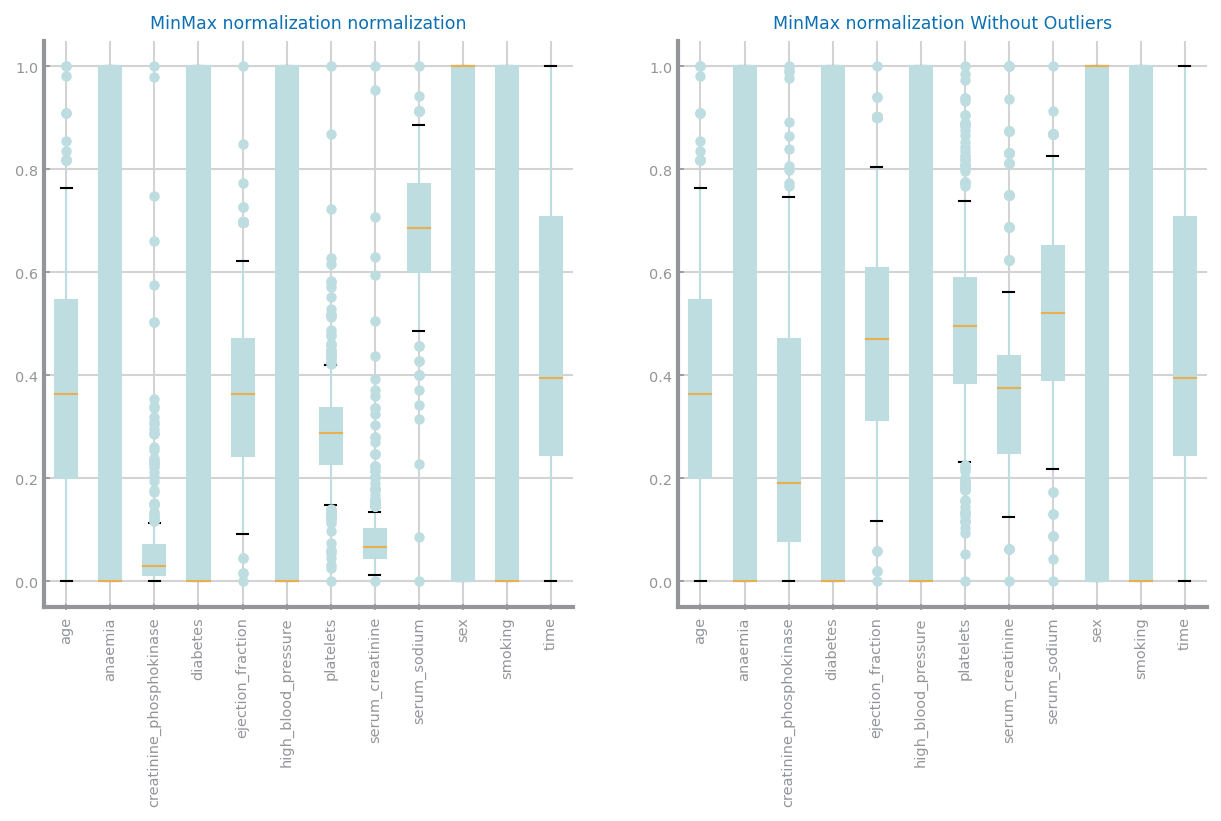

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10,5),squeeze=False )
axs[0, 0].set_title('MinMax normalization normalization')
norm_data_minmax.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('MinMax normalization Without Outliers')
# axs[0, 2].xticks(rotation=90)
norm_data_minmax_clean.boxplot(ax=axs[0, 1])
# fig.tight_layout()
for i in range(2):
    plt.setp(axs[0, i].xaxis.get_majorticklabels(), rotation=90)
    
plt.show()

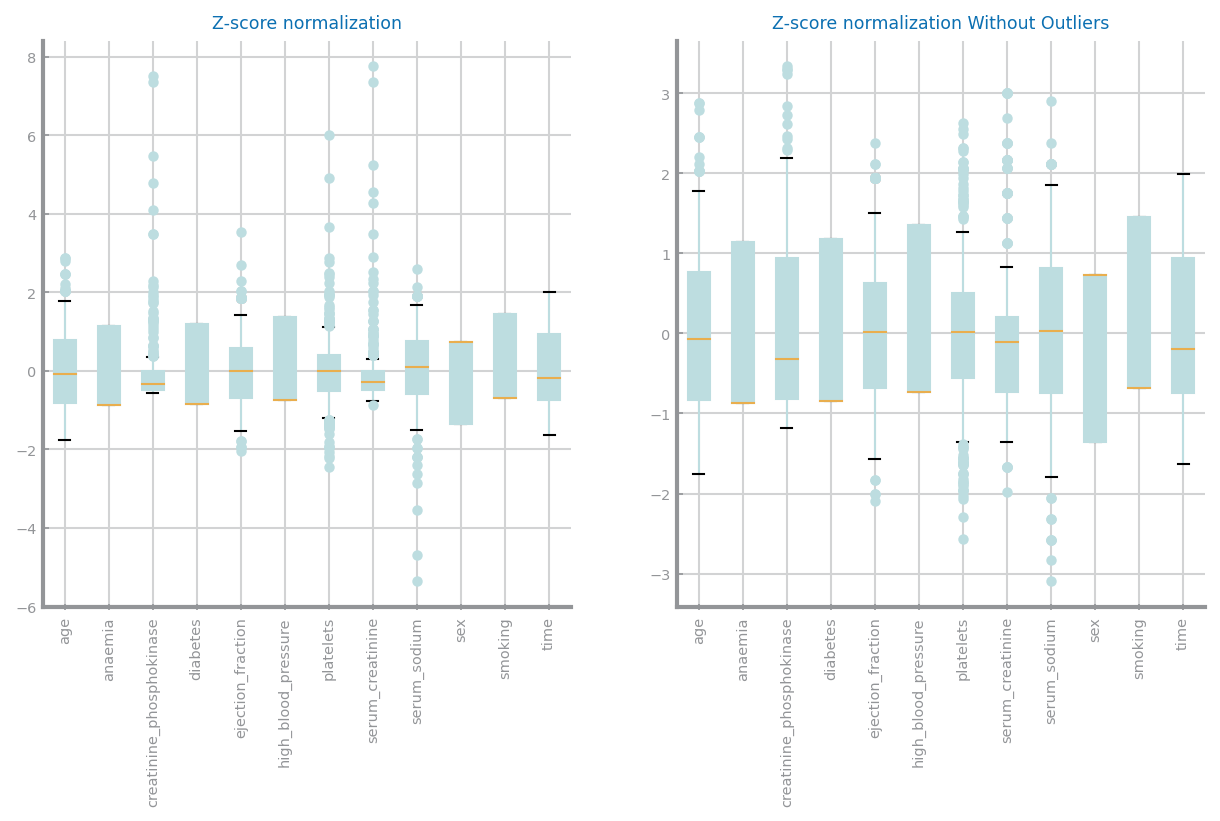

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10,5),squeeze=False )
axs[0, 0].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization Without Outliers')
# axs[0, 2].xticks(rotation=90)
norm_data_zscore_clean.boxplot(ax=axs[0, 1])
# fig.tight_layout()
for i in range(2):
    plt.setp(axs[0, i].xaxis.get_majorticklabels(), rotation=90)
    
plt.show()

# Decision Trees

<Figure size 600x450 with 0 Axes>

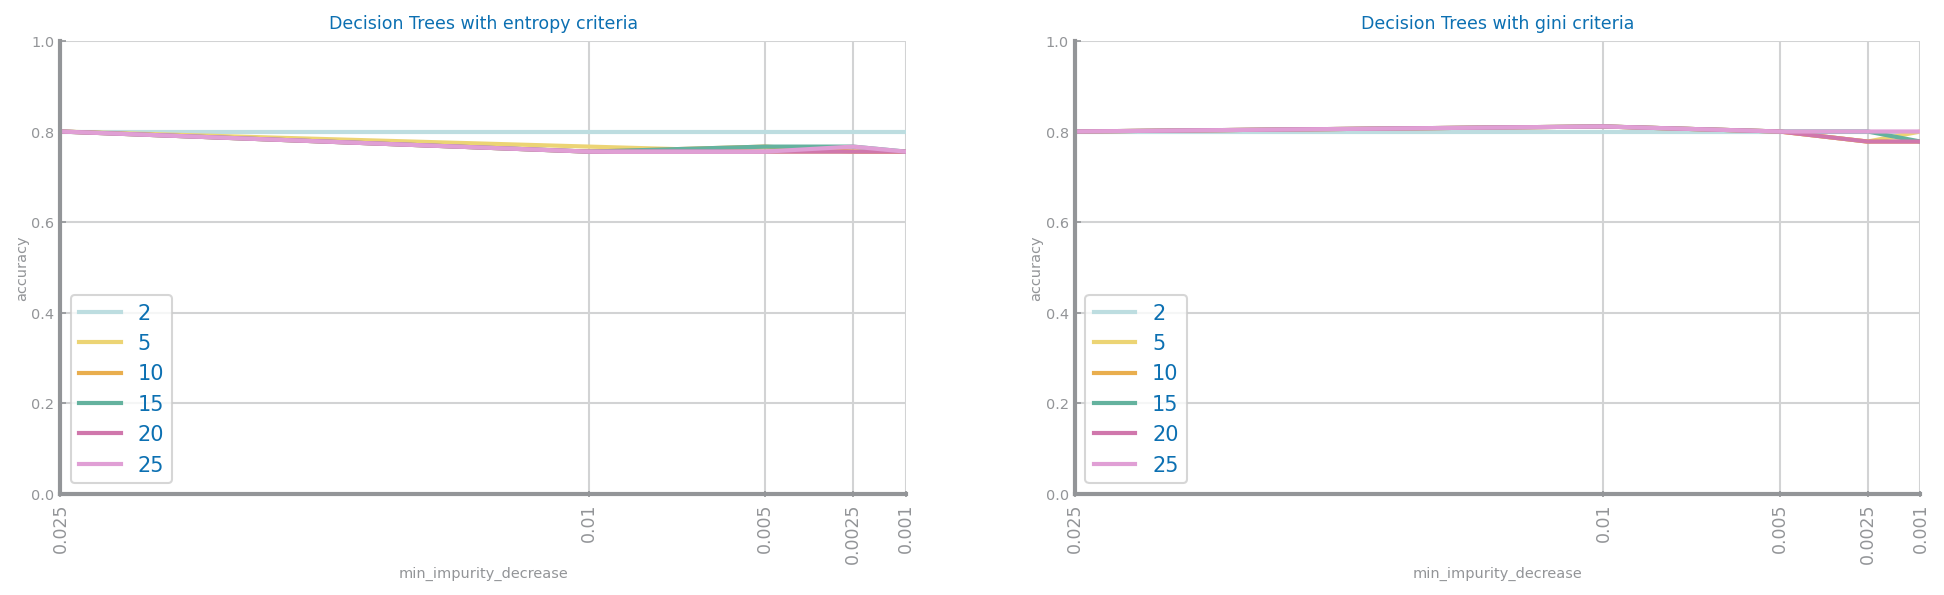

Best results achieved with gini criteria, depth=5 and min_impurity_decrease=0.01 ==> accuracy=0.81


In [15]:
data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
original_data = data.copy()
y: np.ndarray = original_data.pop('DEATH_EVENT').values
X: np.ndarray = original_data.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None
n = 6
plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

### Decision Trees with normalized data

<Figure size 600x450 with 0 Axes>

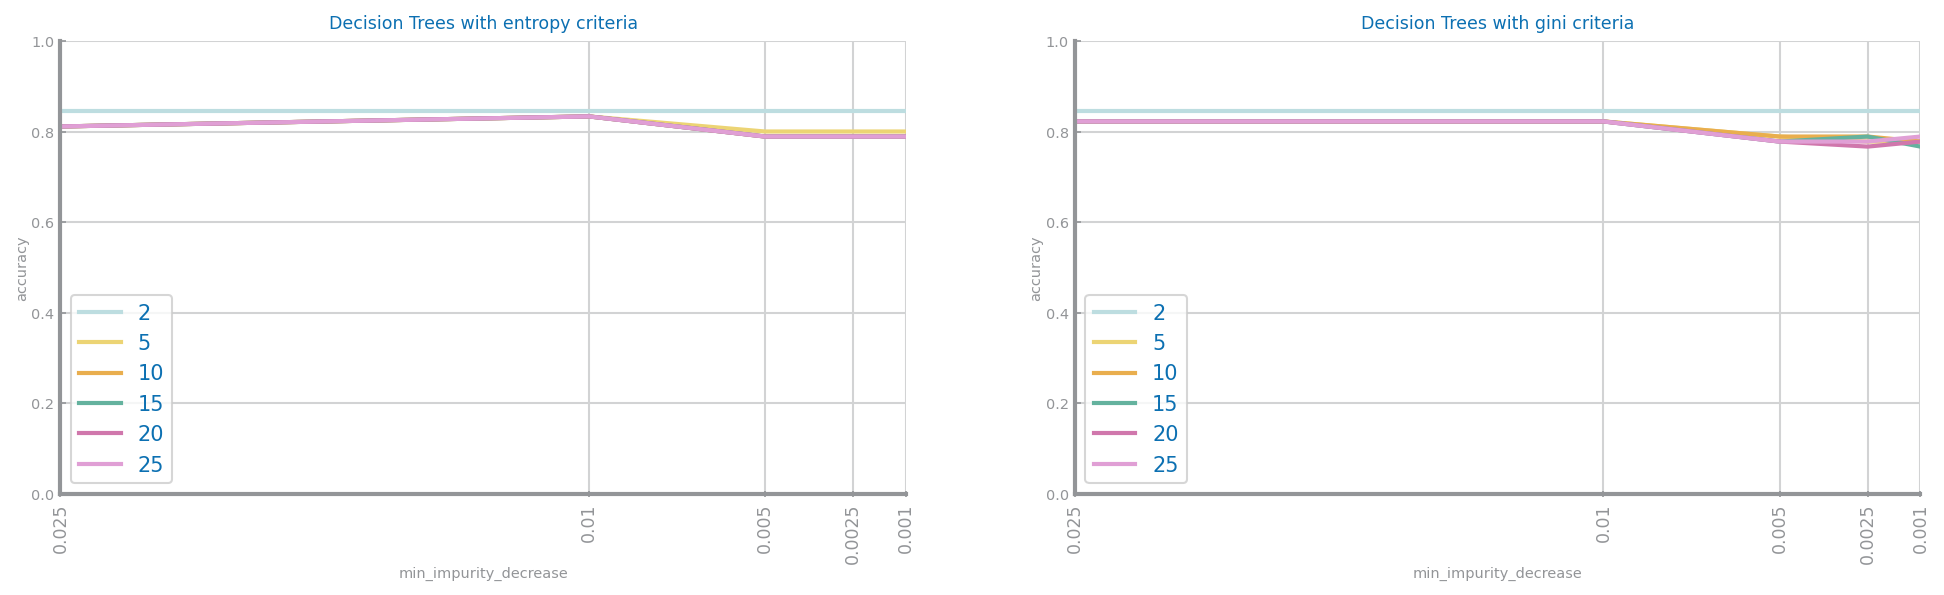

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=0.84


In [16]:
minmax_clean = norm_data_minmax_clean.copy()
y: np.ndarray = minmax_clean.pop('DEATH_EVENT').values
X: np.ndarray = minmax_clean.values
labels = pd.unique(y)
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None
n = 5
plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

Confusion Matrix Test
TruePositives:  19
FalsePositives:  4
TrueNegatives:  57
FalseNegatives:  10


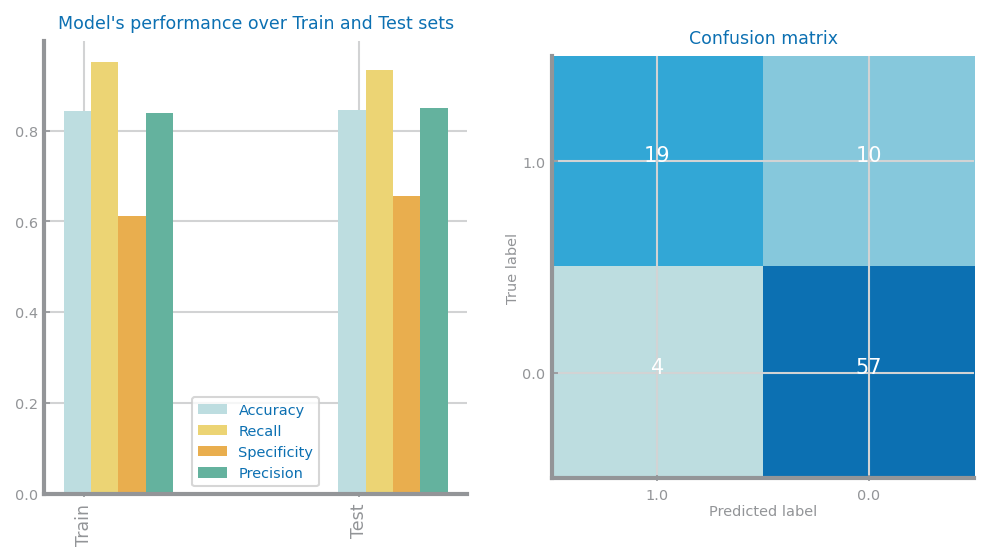

In [17]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

In [18]:
def decision_tree_kfold(num_splits_kfold, data, n=5, stratified=True):
    orig_data = data.copy()
    y: np.ndarray = orig_data.pop('DEATH_EVENT').values
    X: np.ndarray = orig_data.values
    labels = pd.unique(y)
    
    if stratified:
        cv = StratifiedKFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X, y)
    else:
        cv = KFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X)
        
    for train_index, test_index in cv_split:
        trnX, tstX = X[train_index], X[test_index]
        trnY, tstY = y[train_index], y[test_index]
        best = ('',  0, 0.0)
        last_best = 0
        best_tree = None

        min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
        max_depths = [2, 5, 10, 15, 20, 25]
        criteria = ['entropy', 'gini']
        plt.figure()
        fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
        for k in range(len(criteria)):
            f = criteria[k]
            values = {}
            for d in max_depths:
                yvalues = []
                for imp in min_impurity_decrease:
                    tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp)
                    tree.fit(trnX, trnY)
                    prdY = tree.predict(tstX)
                    yvalues.append(metrics.accuracy_score(tstY, prdY))
                    if yvalues[-1] > last_best:
                        best = (f, d, imp)
                        last_best = yvalues[-1]
                        best_tree = tree

                values[d] = yvalues
            ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                                   xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

        plt.show()
        print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

    prd_trn = best_tree.predict(trnX)
    prd_tst = best_tree.predict(tstX)
    ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

    dot_data = export_graphviz(best_tree, out_file='dtree.dot', filled=True, rounded=True, special_characters=True)
    call(['dot', '-Tpng', 'dtree.dot', '-o', 'dtree.png', '-Gdpi=600']) # Convert to png
    if best_tree.tree_.node_count > 10:
        plt.figure(figsize = (14, 18))
    else:
        plt.figure(figsize = (7, 5))
    plt.imshow(plt.imread('dtree.png'))
    plt.axis('off')
    plt.title("Learned tree for " + ("Stratified " if stratified else "") + "K-Folds cross-validator")
    plt.show()

<Figure size 600x450 with 0 Axes>

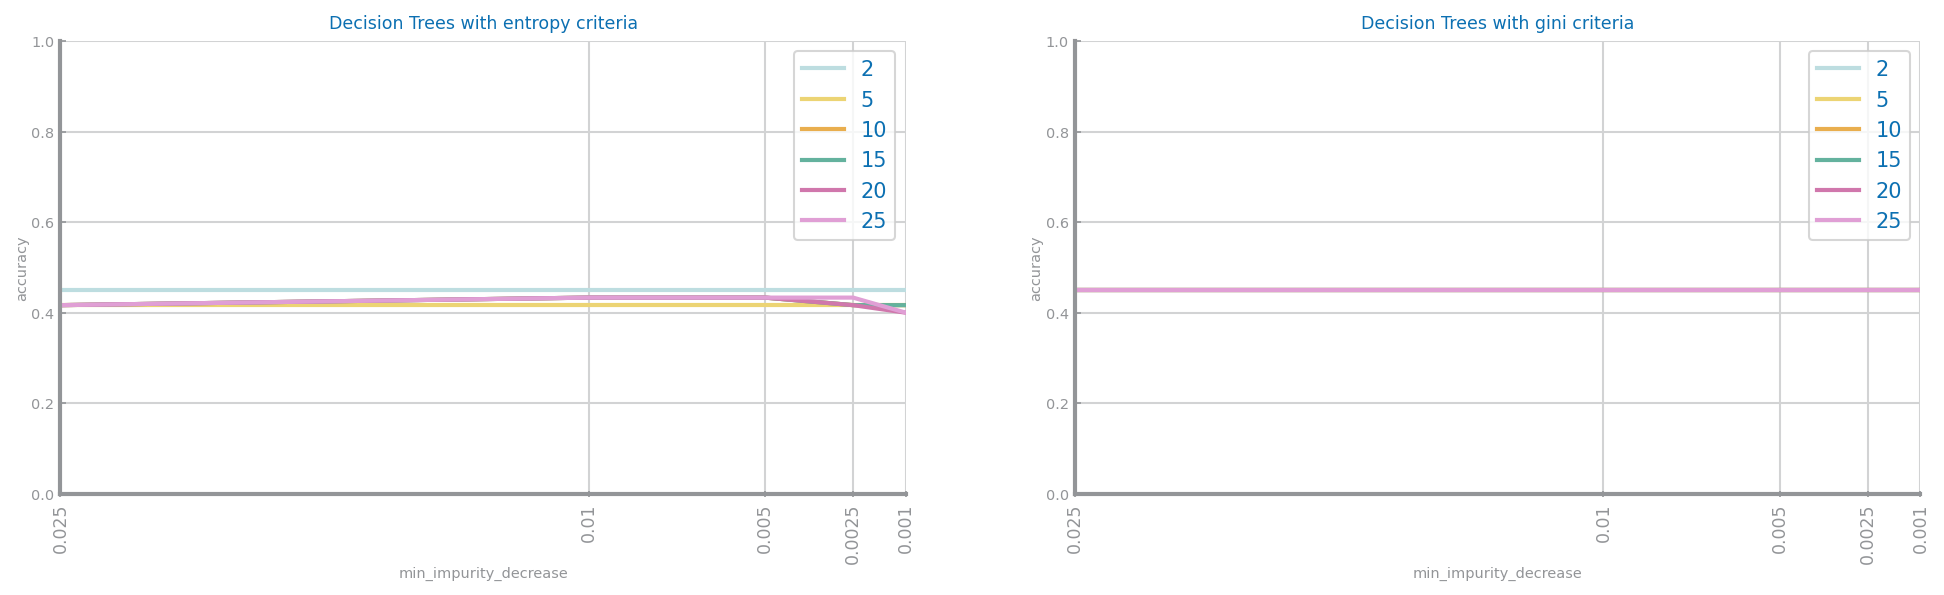

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=0.45


<Figure size 600x450 with 0 Axes>

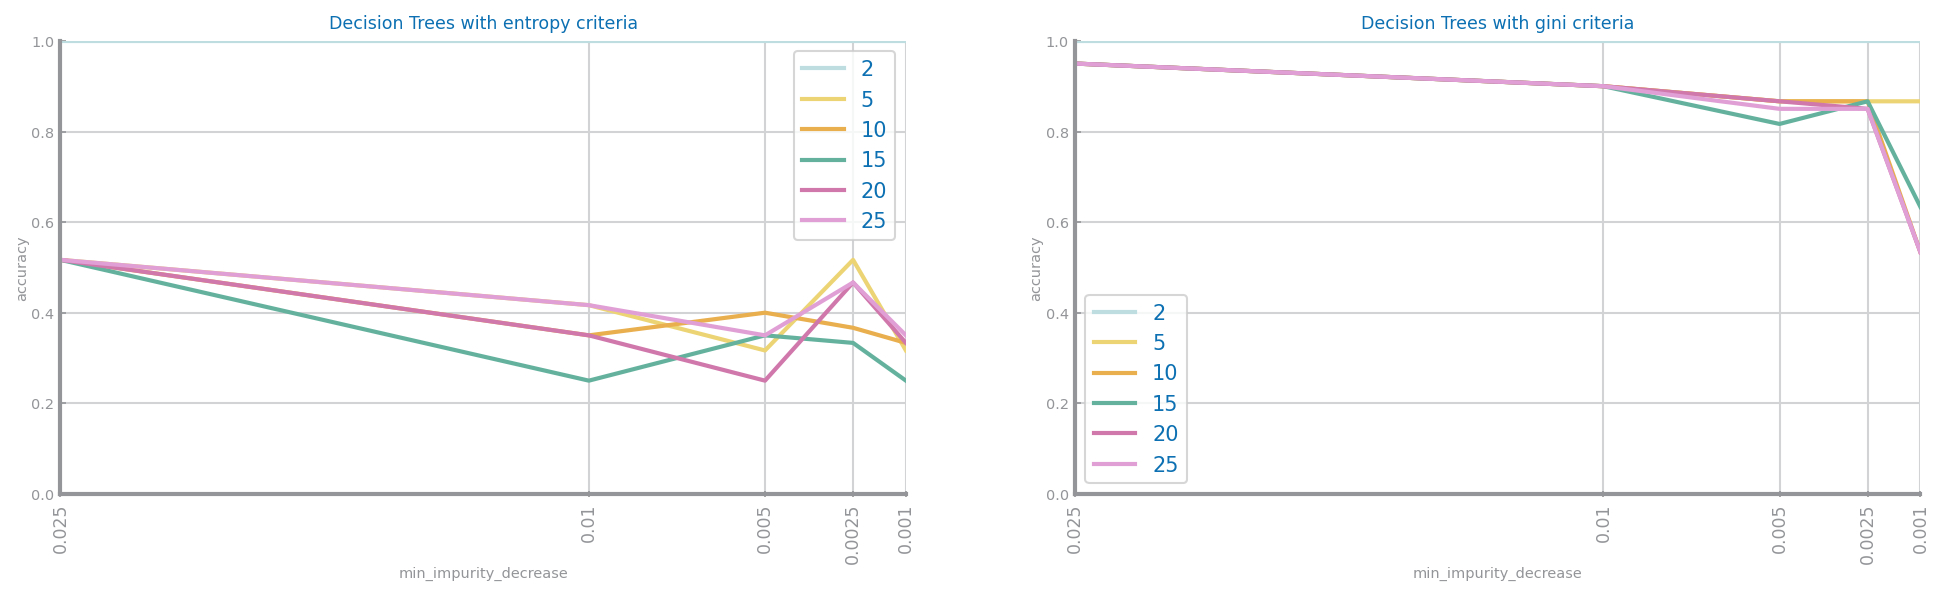

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=1.00


<Figure size 600x450 with 0 Axes>

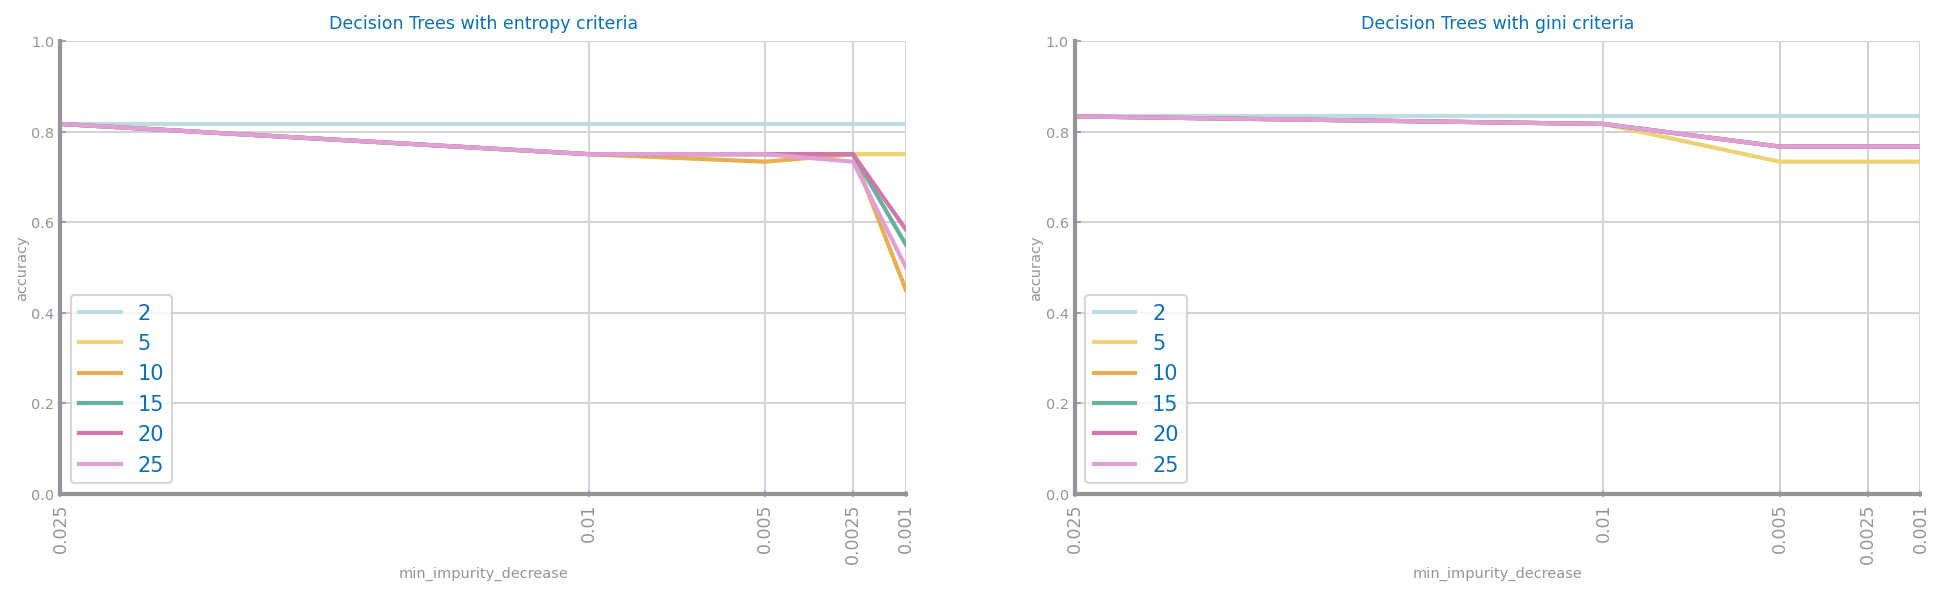

Best results achieved with gini criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=0.83


<Figure size 600x450 with 0 Axes>

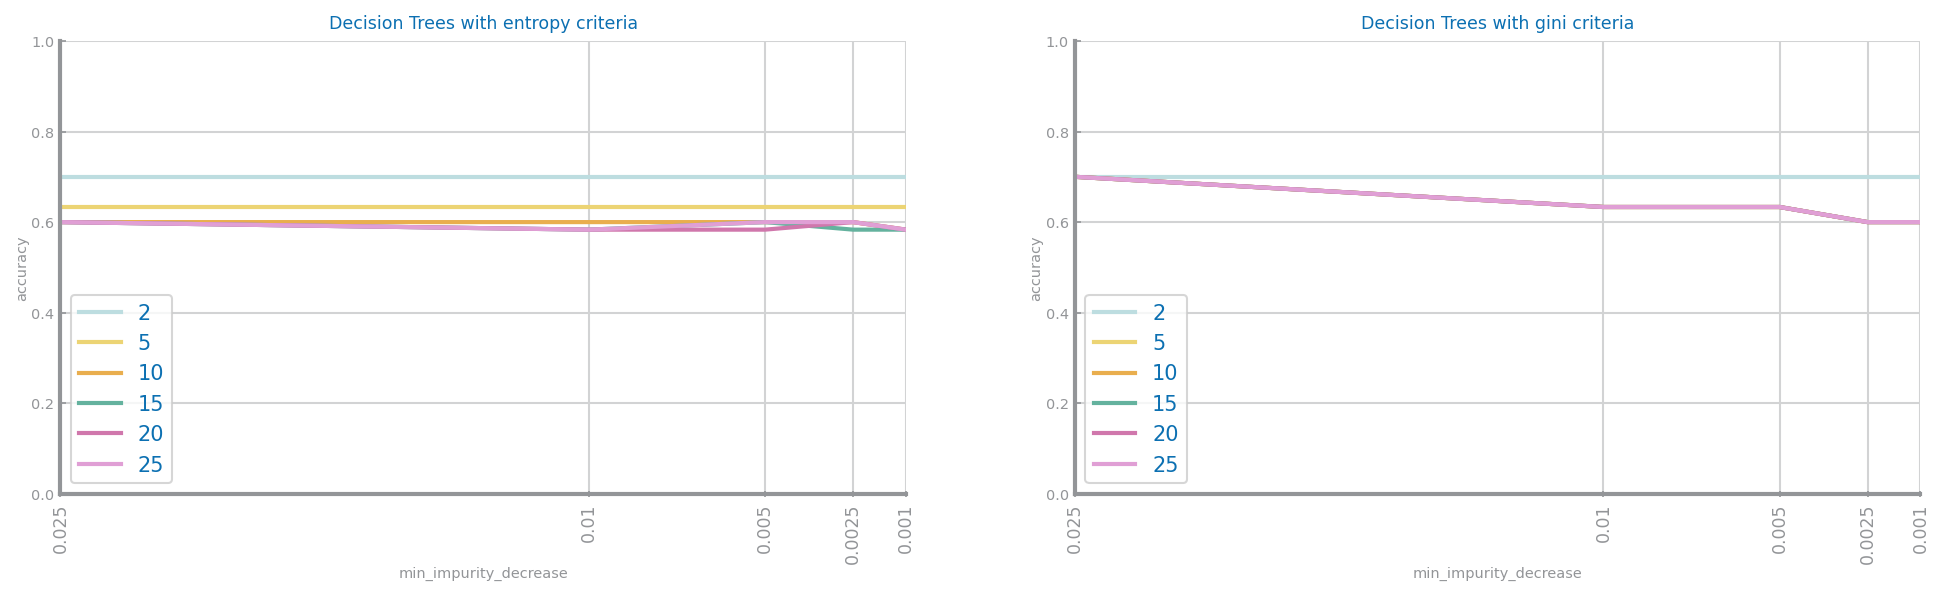

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=0.70


<Figure size 600x450 with 0 Axes>

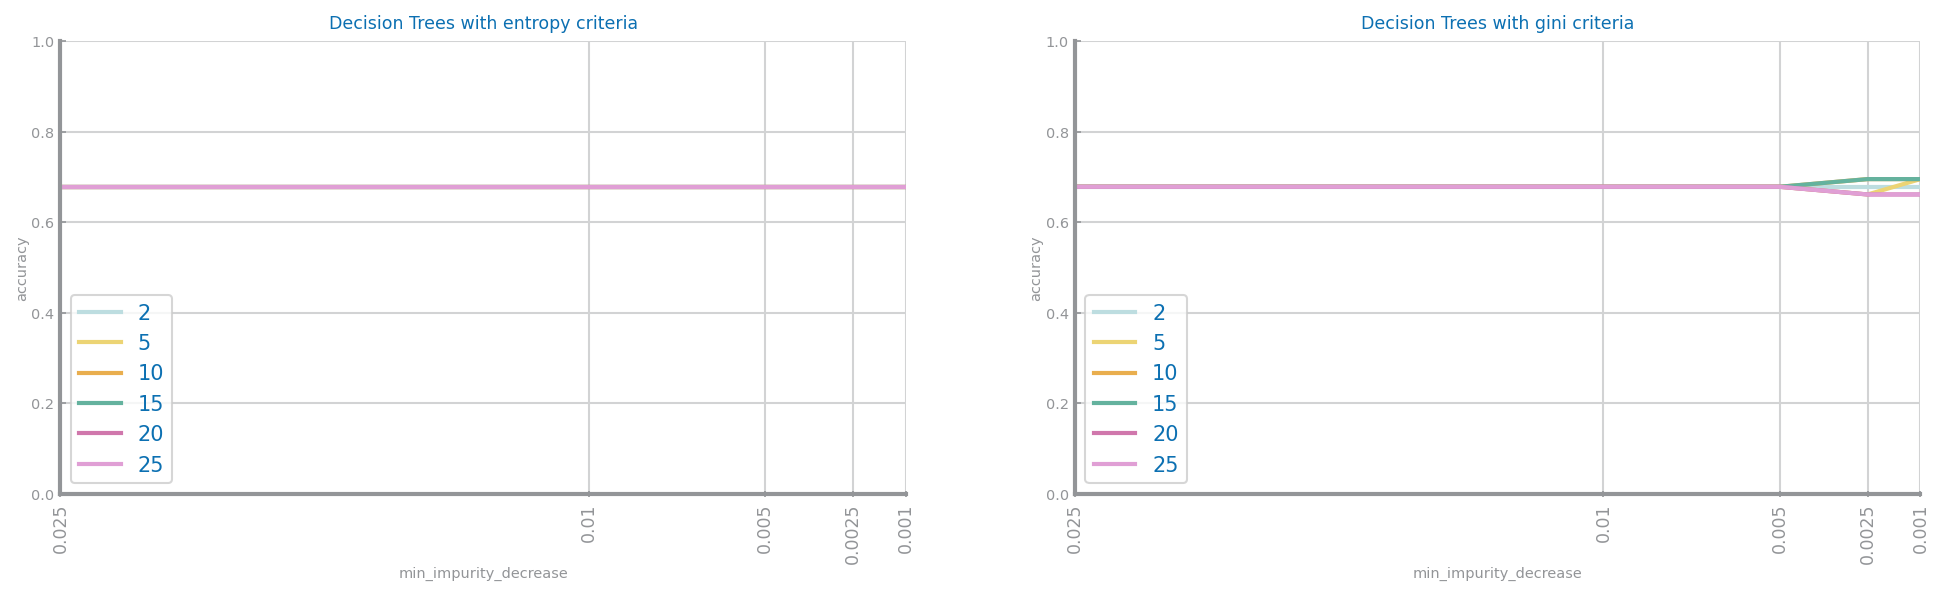

Best results achieved with gini criteria, depth=5 and min_impurity_decrease=0.00 ==> accuracy=0.69
Confusion Matrix Test
TruePositives:  1
FalsePositives:  0
TrueNegatives:  40
FalseNegatives:  18


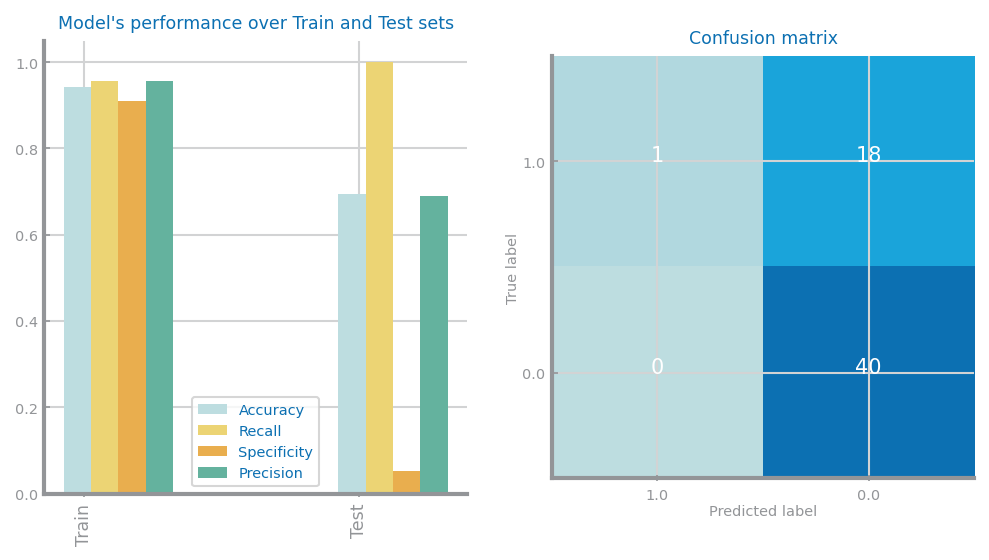

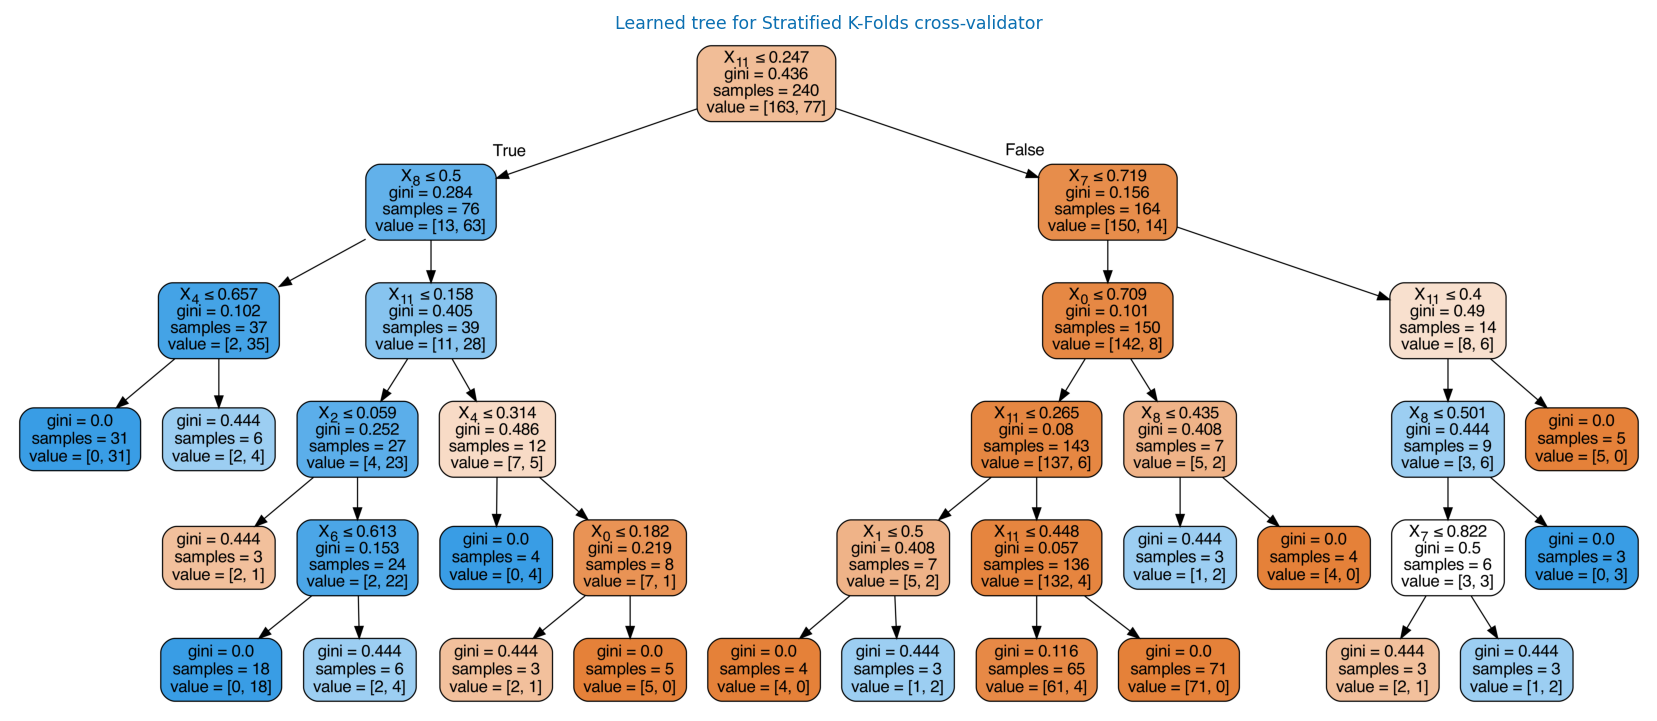

In [19]:
decision_tree_kfold(num_splits_kfold=5, data=norm_data_minmax_clean,n=3, stratified=True)

<Figure size 600x450 with 0 Axes>

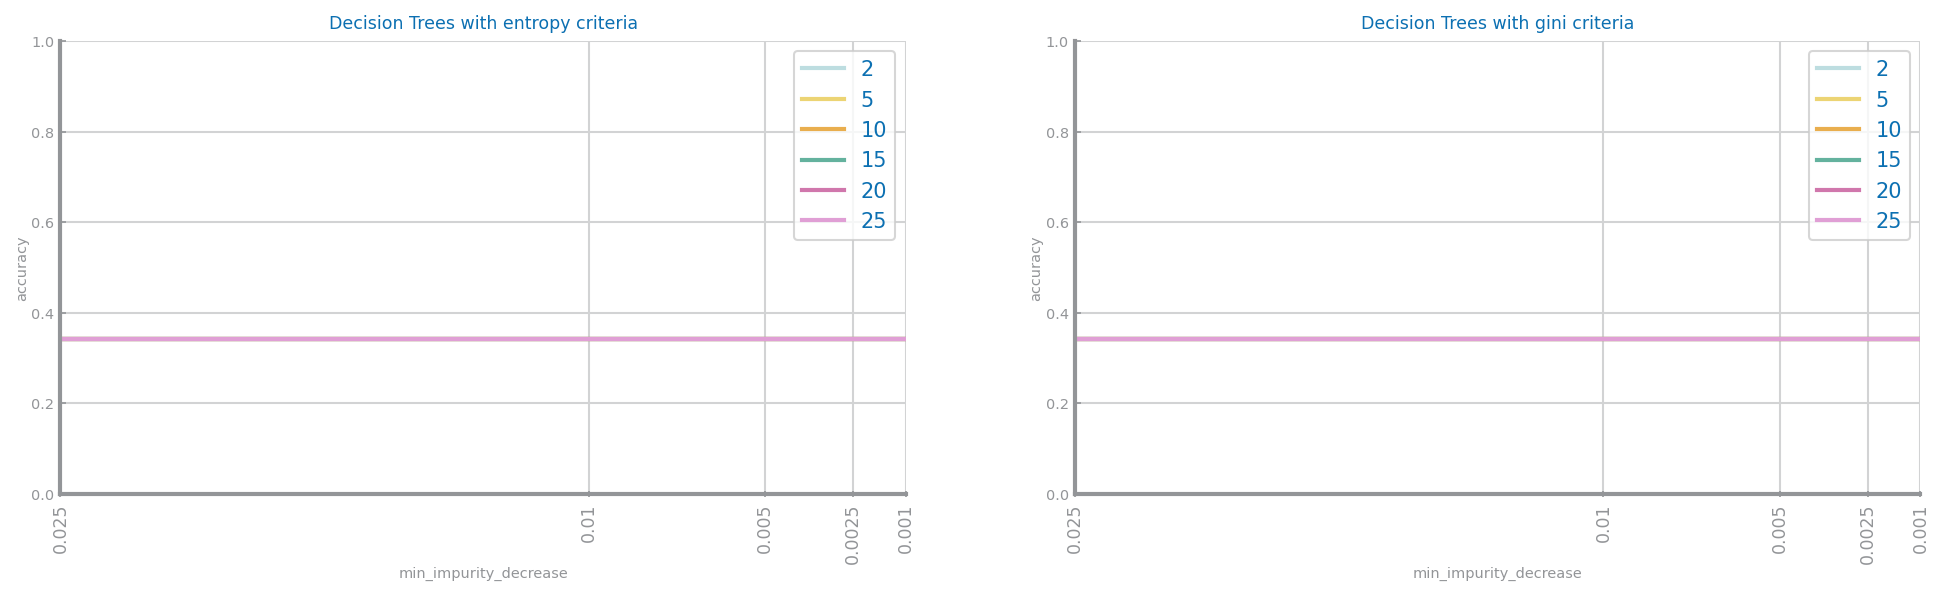

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=0.34


<Figure size 600x450 with 0 Axes>

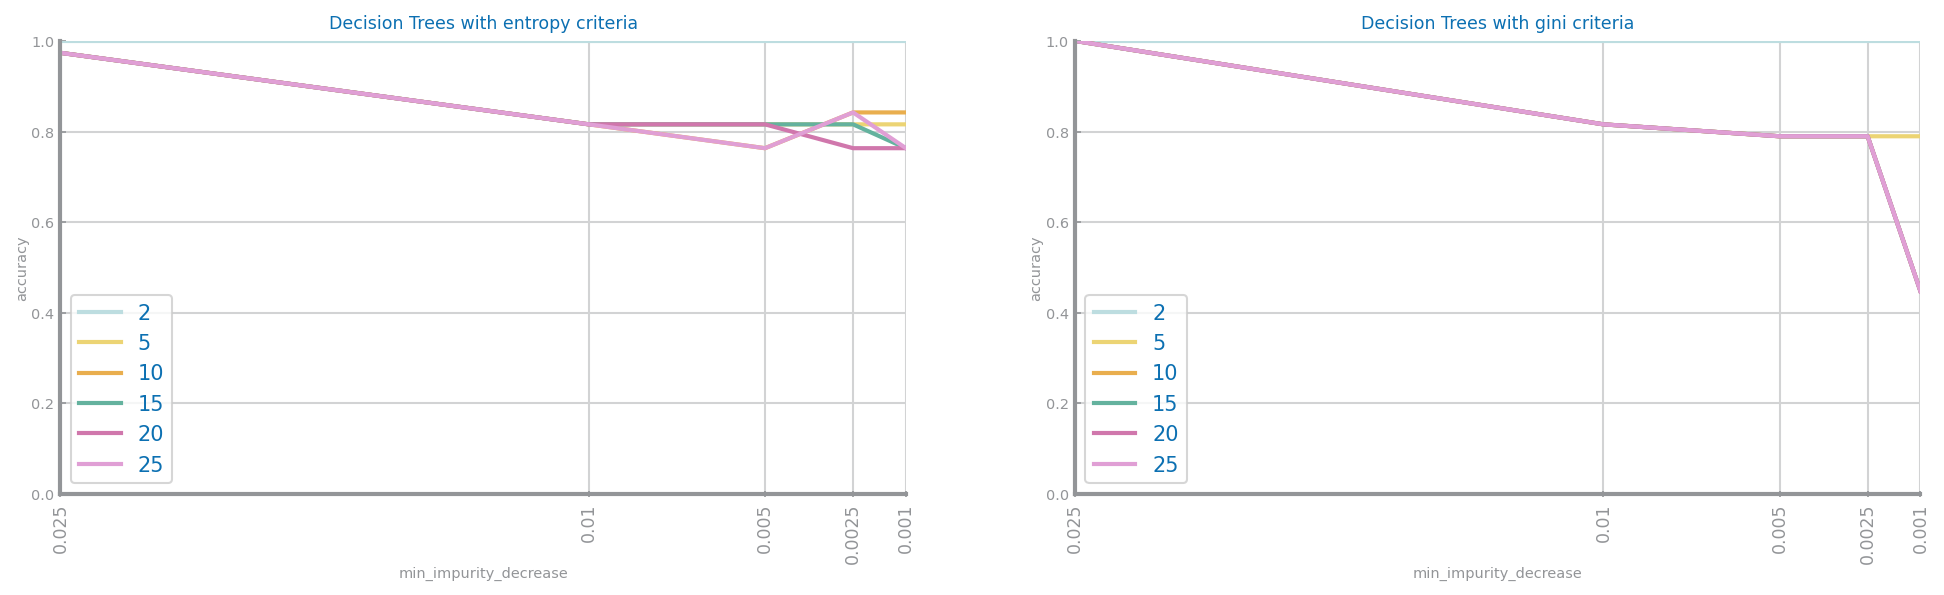

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=1.00


<Figure size 600x450 with 0 Axes>

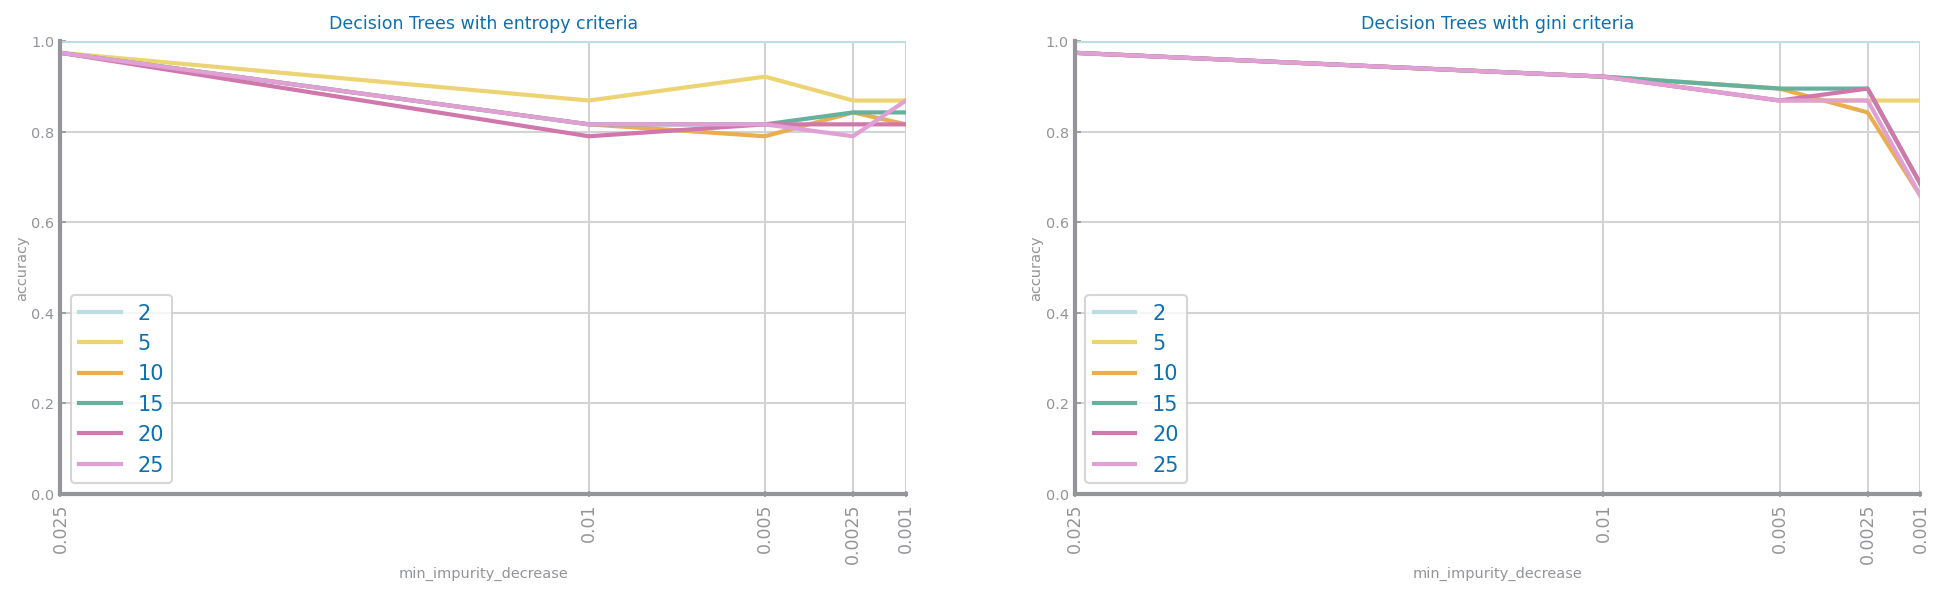

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=1.00


<Figure size 600x450 with 0 Axes>

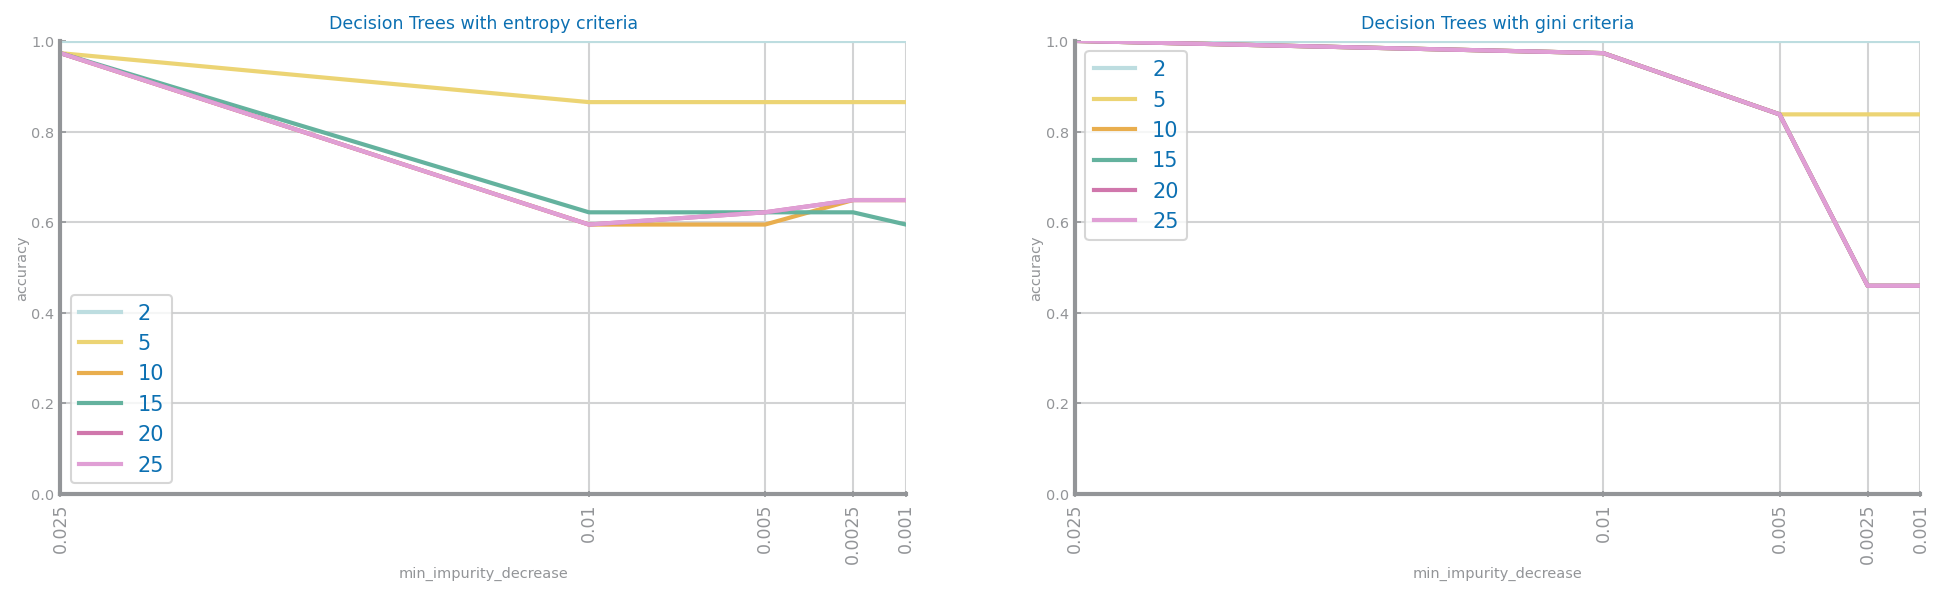

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=1.00


<Figure size 600x450 with 0 Axes>

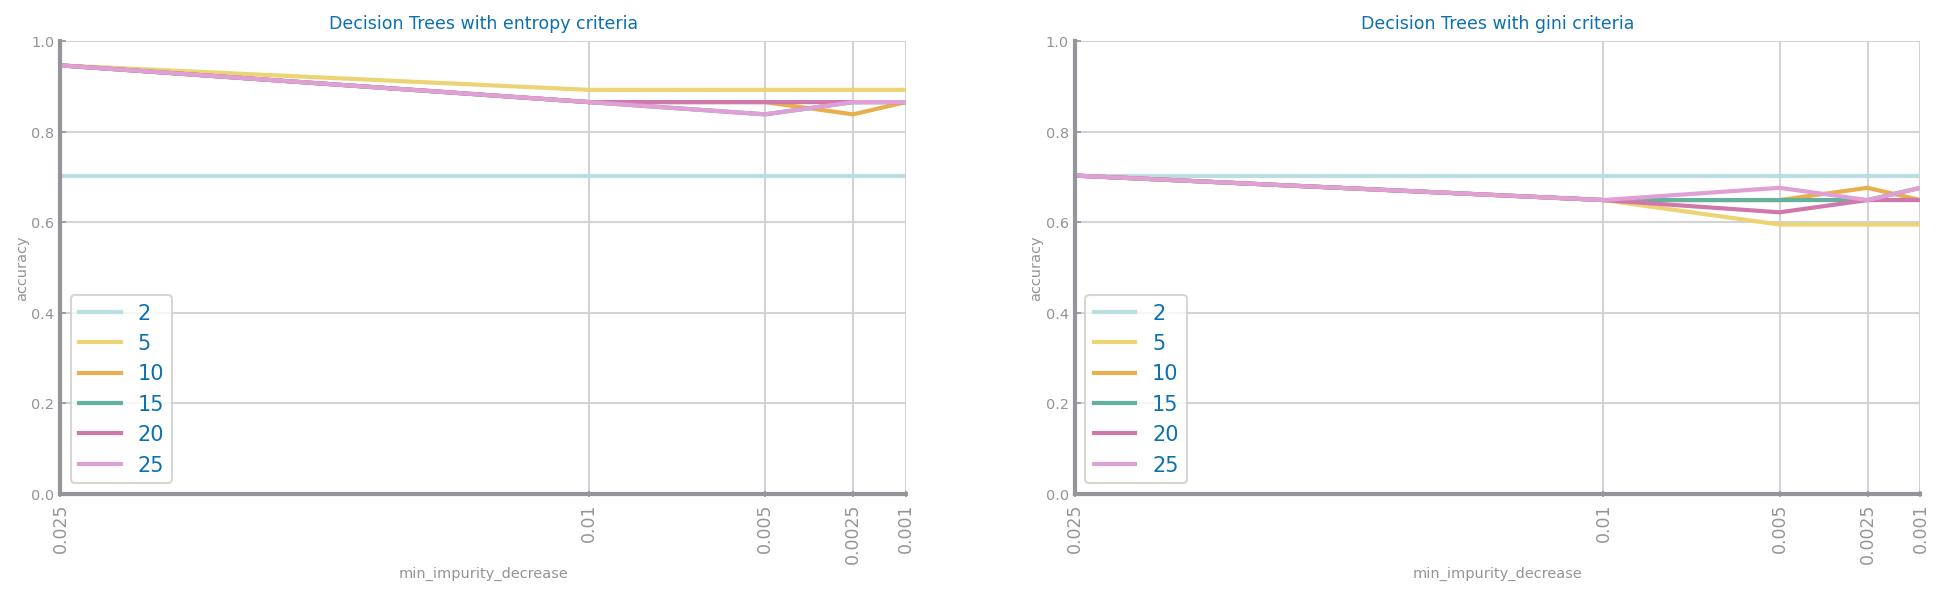

Best results achieved with entropy criteria, depth=5 and min_impurity_decrease=0.03 ==> accuracy=0.95


<Figure size 600x450 with 0 Axes>

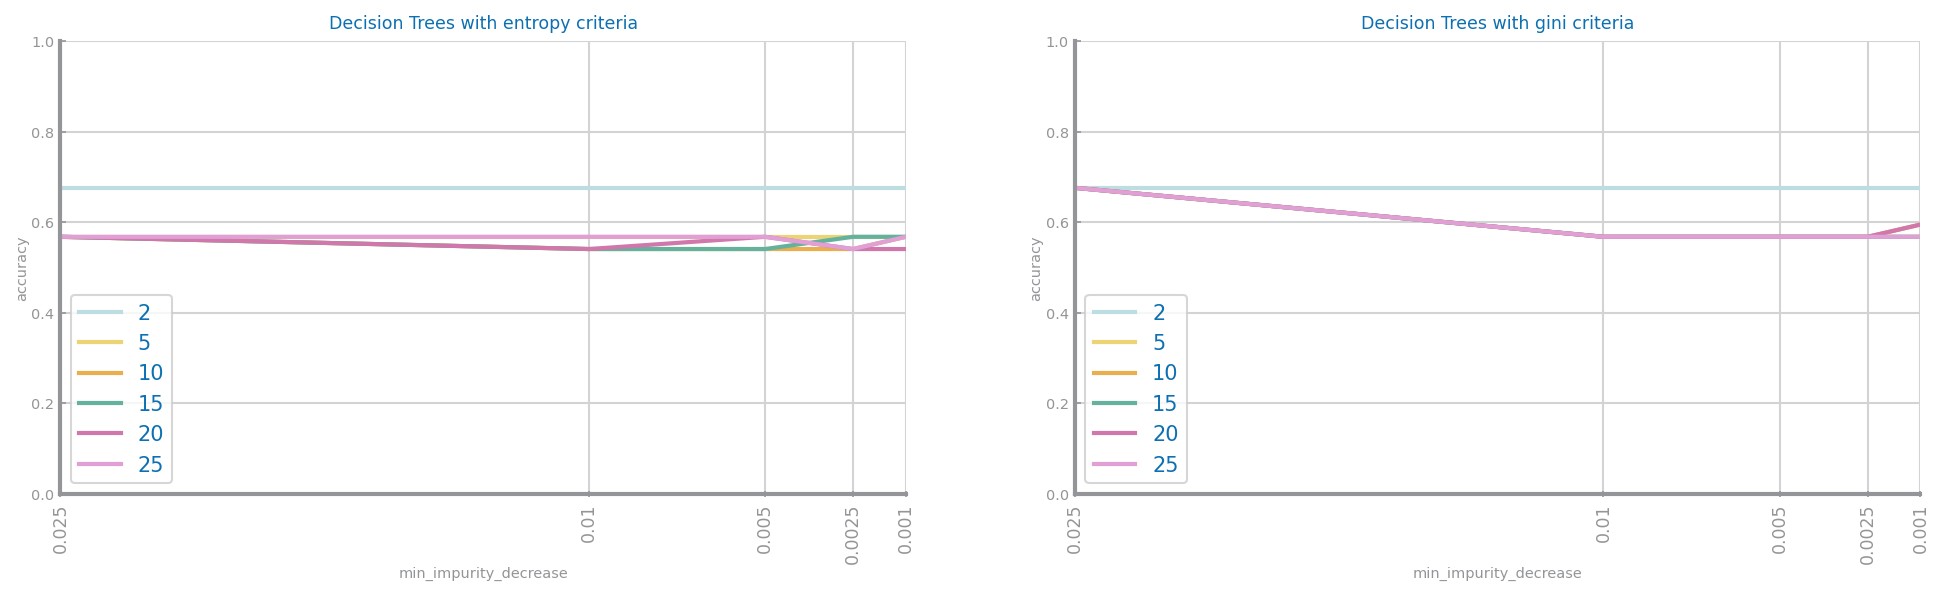

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=0.68


<Figure size 600x450 with 0 Axes>

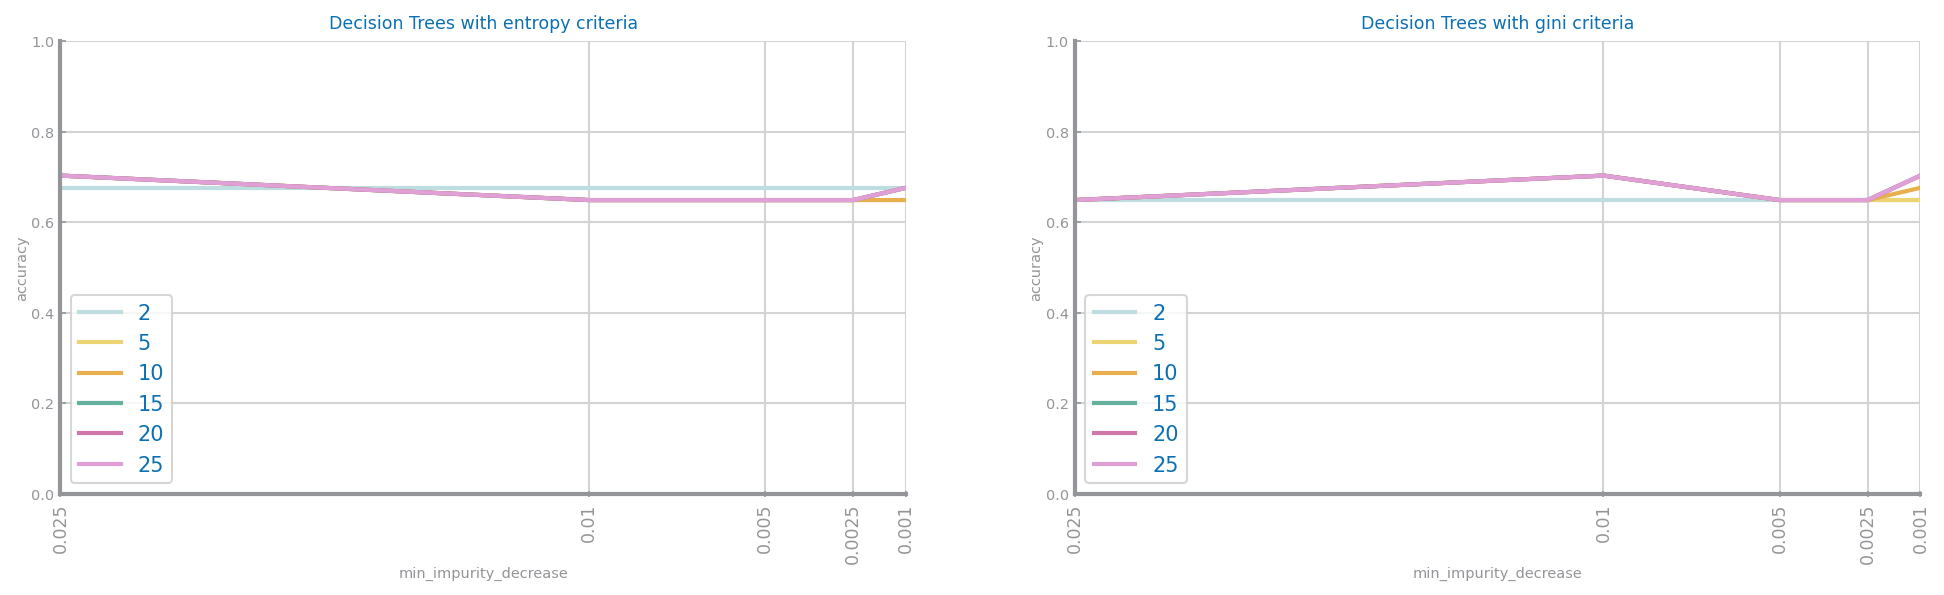

Best results achieved with entropy criteria, depth=5 and min_impurity_decrease=0.03 ==> accuracy=0.70


<Figure size 600x450 with 0 Axes>

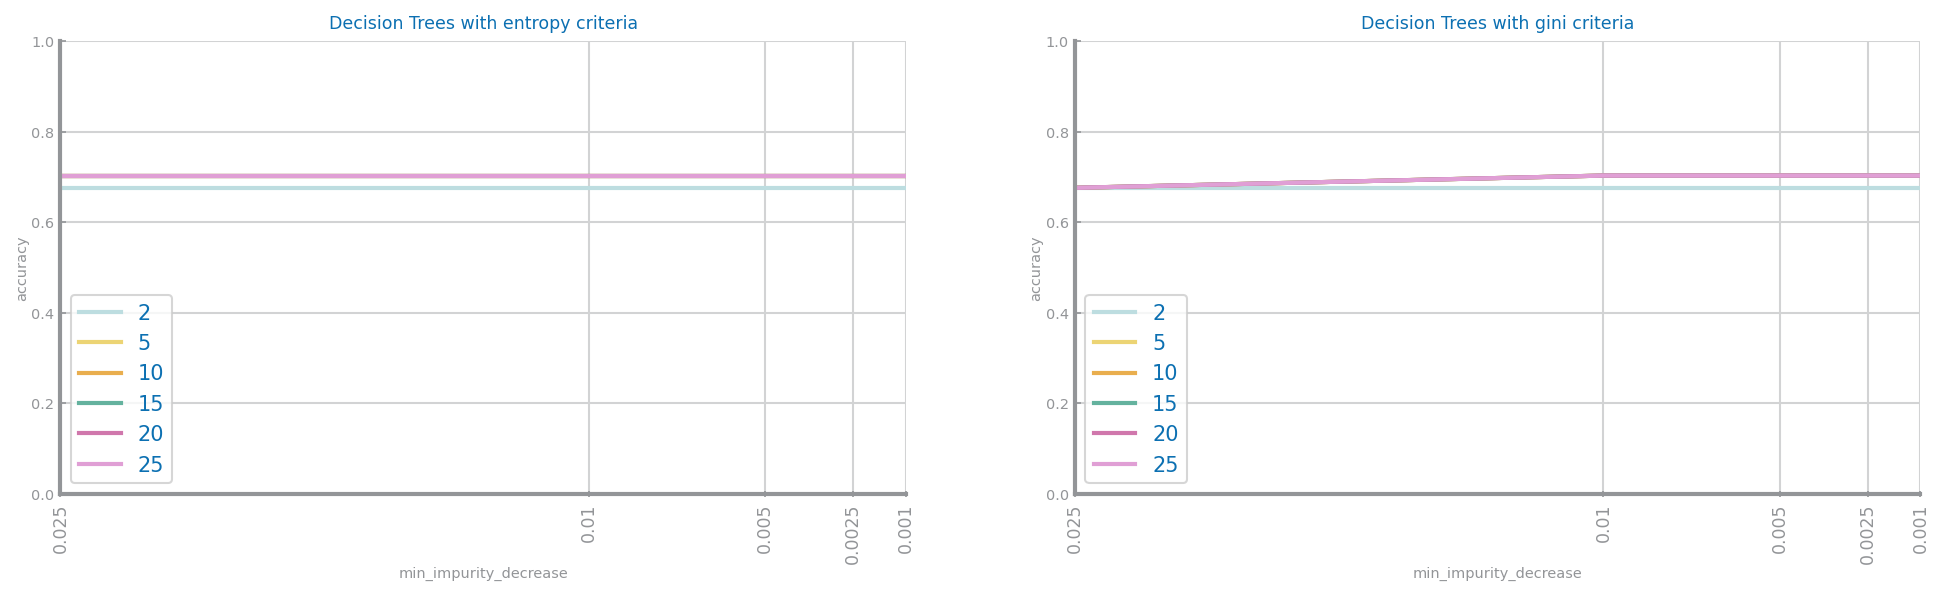

Best results achieved with entropy criteria, depth=5 and min_impurity_decrease=0.03 ==> accuracy=0.70
Confusion Matrix Test
TruePositives:  1
FalsePositives:  0
TrueNegatives:  25
FalseNegatives:  11


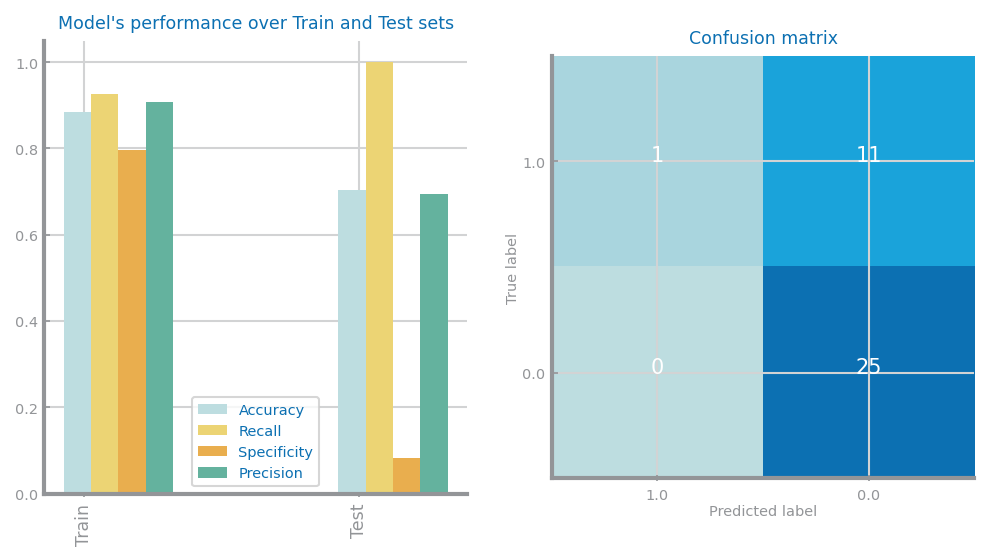

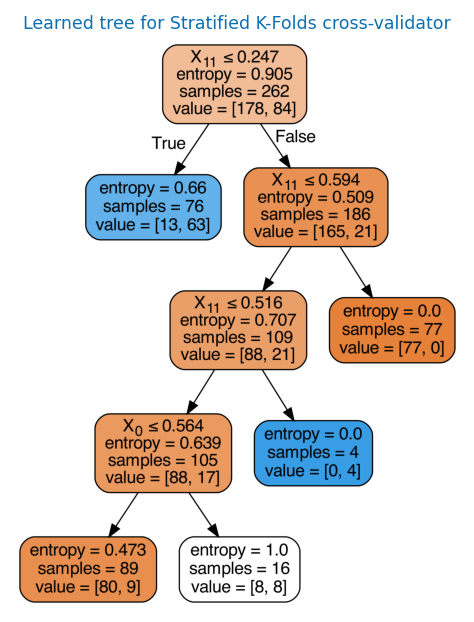

In [20]:
decision_tree_kfold(num_splits_kfold=8, data=norm_data_minmax_clean, n=3, stratified=True)

<Figure size 600x450 with 0 Axes>

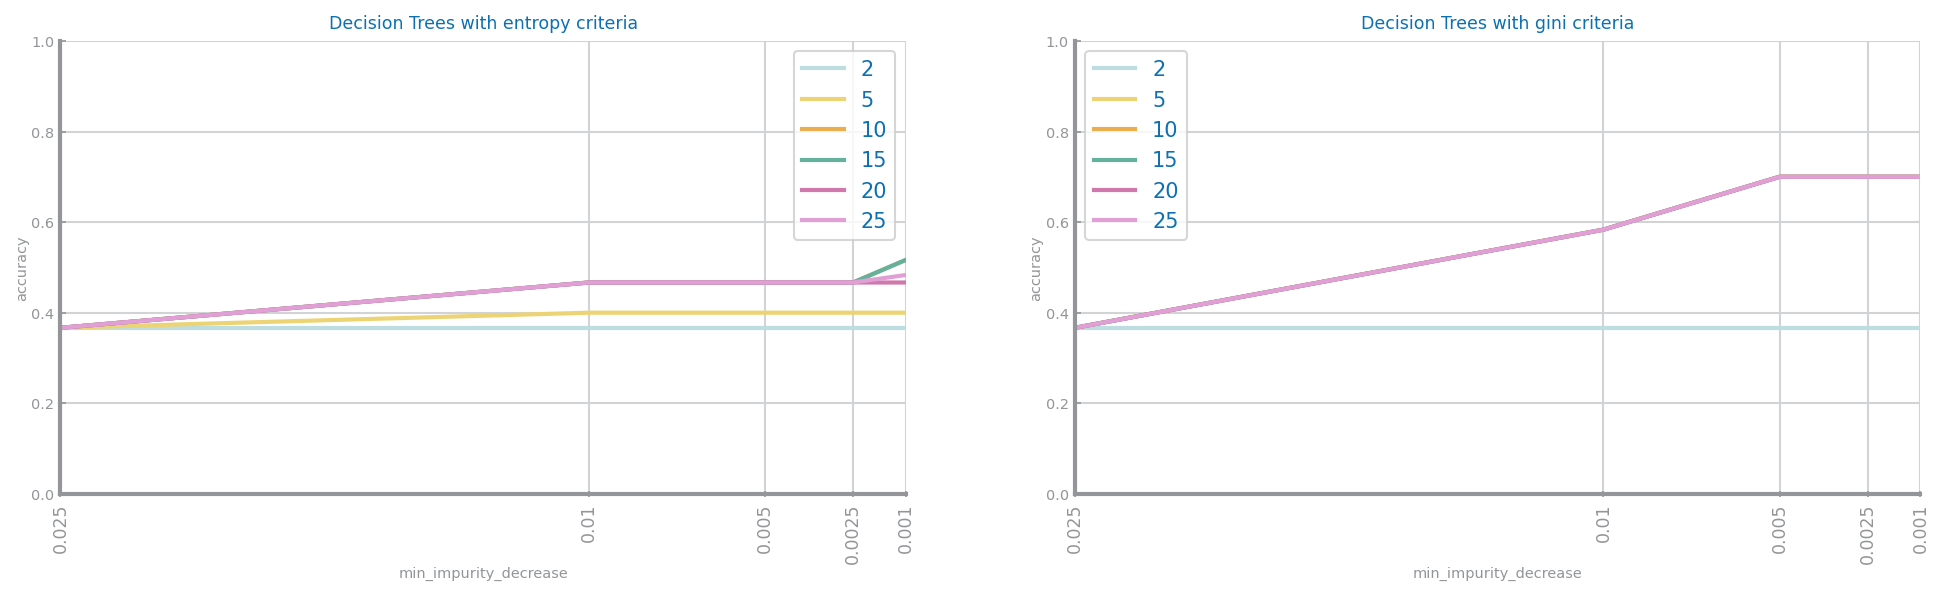

Best results achieved with gini criteria, depth=5 and min_impurity_decrease=0.01 ==> accuracy=0.70


<Figure size 600x450 with 0 Axes>

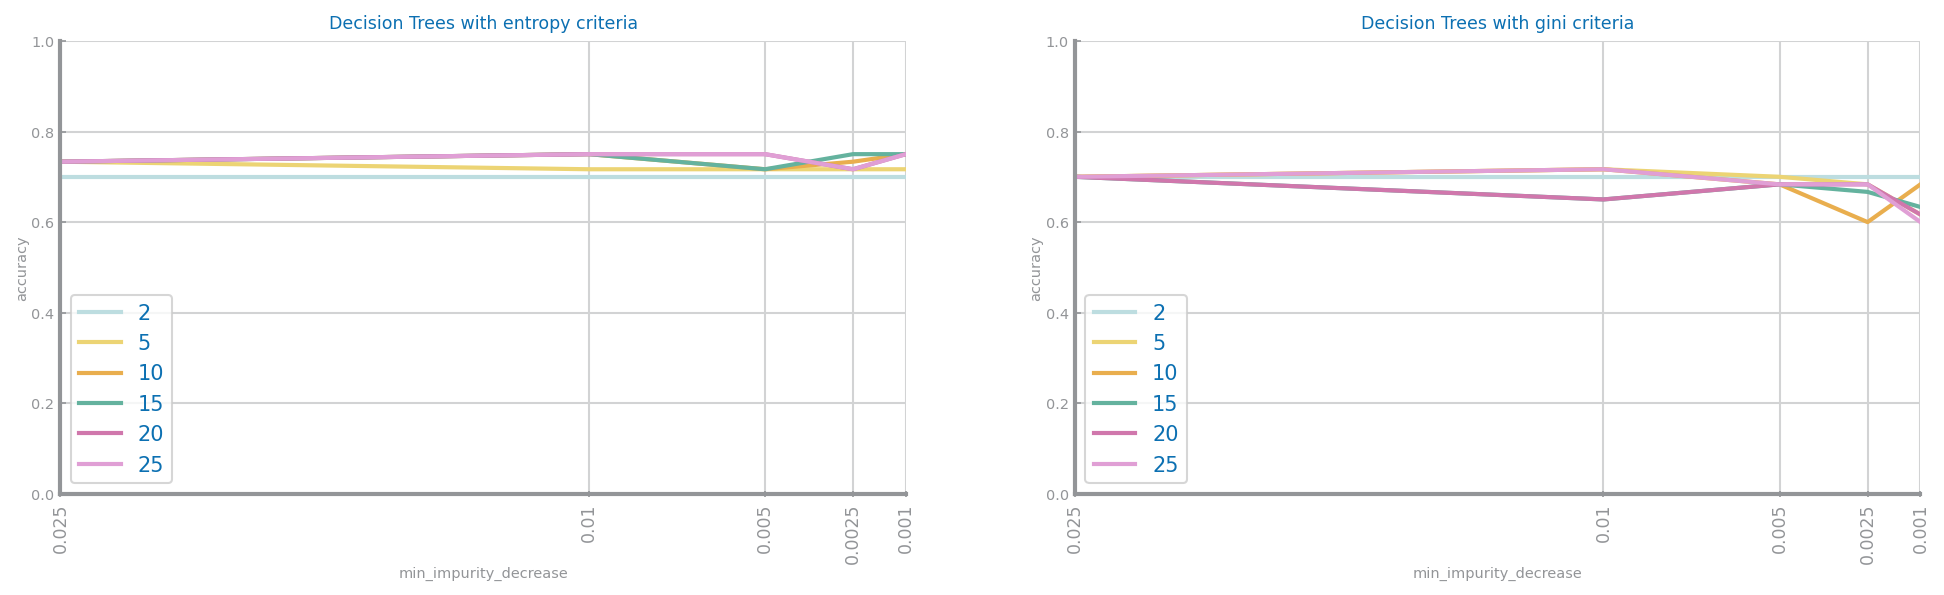

Best results achieved with entropy criteria, depth=10 and min_impurity_decrease=0.01 ==> accuracy=0.75


<Figure size 600x450 with 0 Axes>

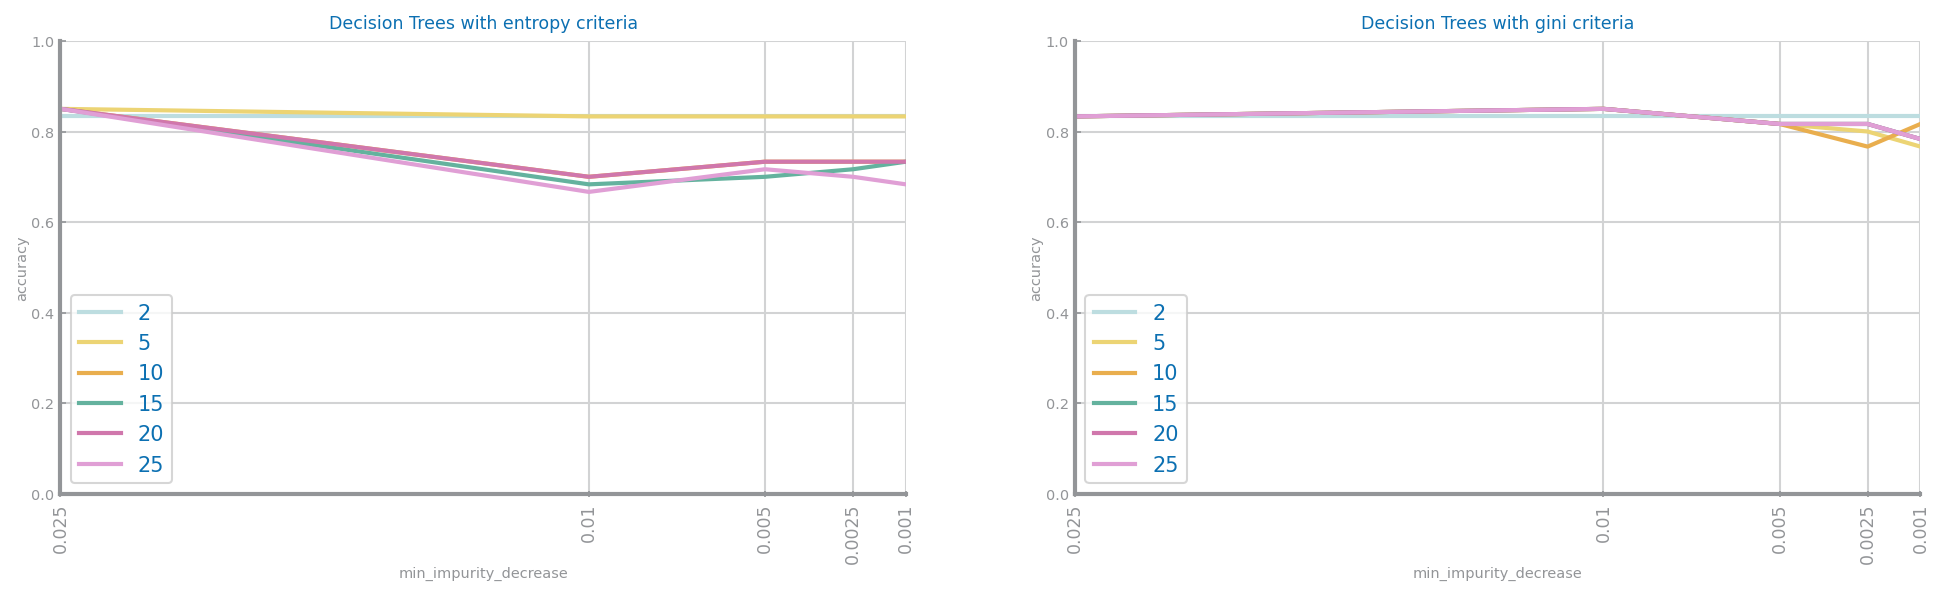

Best results achieved with entropy criteria, depth=5 and min_impurity_decrease=0.03 ==> accuracy=0.85


<Figure size 600x450 with 0 Axes>

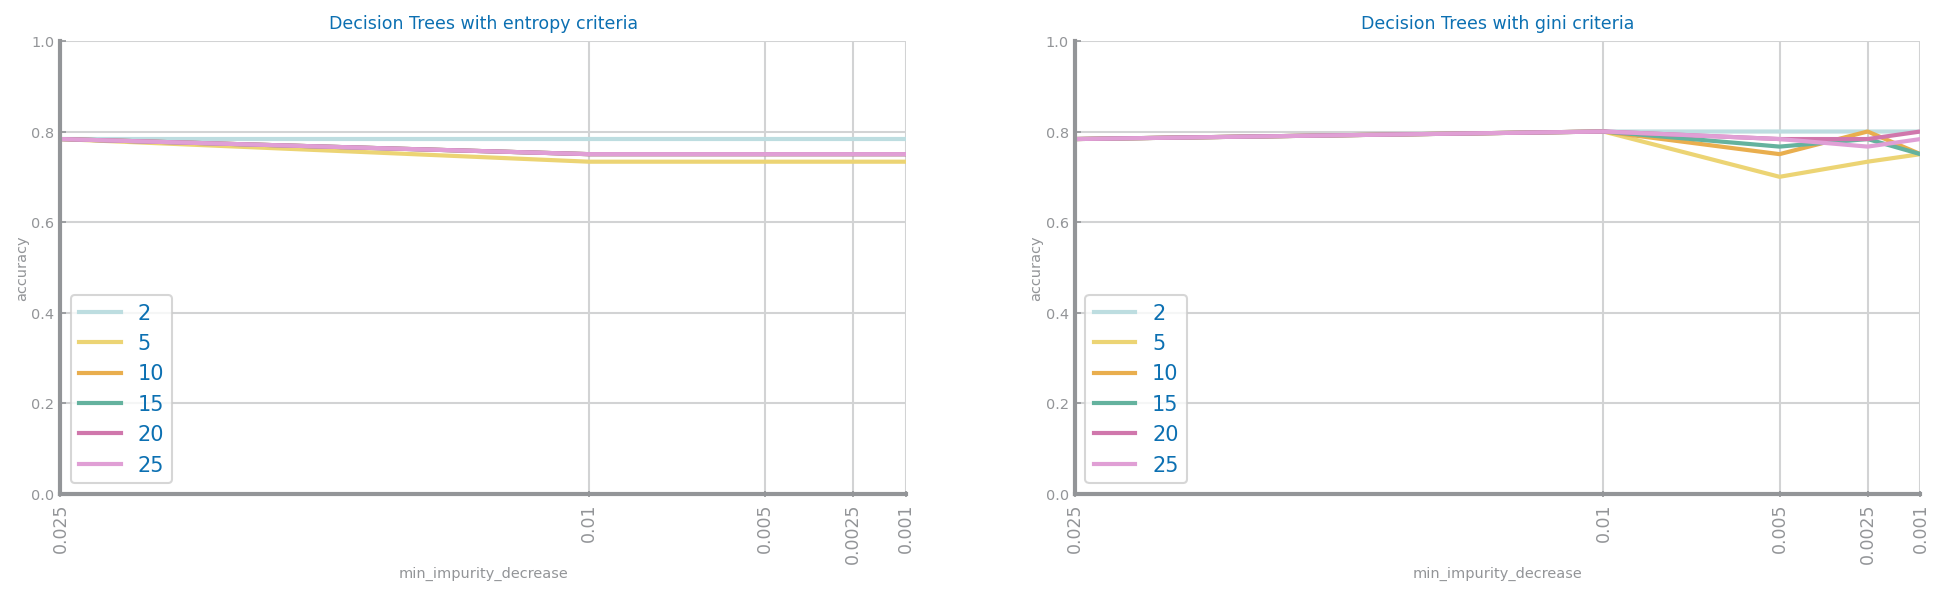

Best results achieved with gini criteria, depth=2 and min_impurity_decrease=0.01 ==> accuracy=0.80


<Figure size 600x450 with 0 Axes>

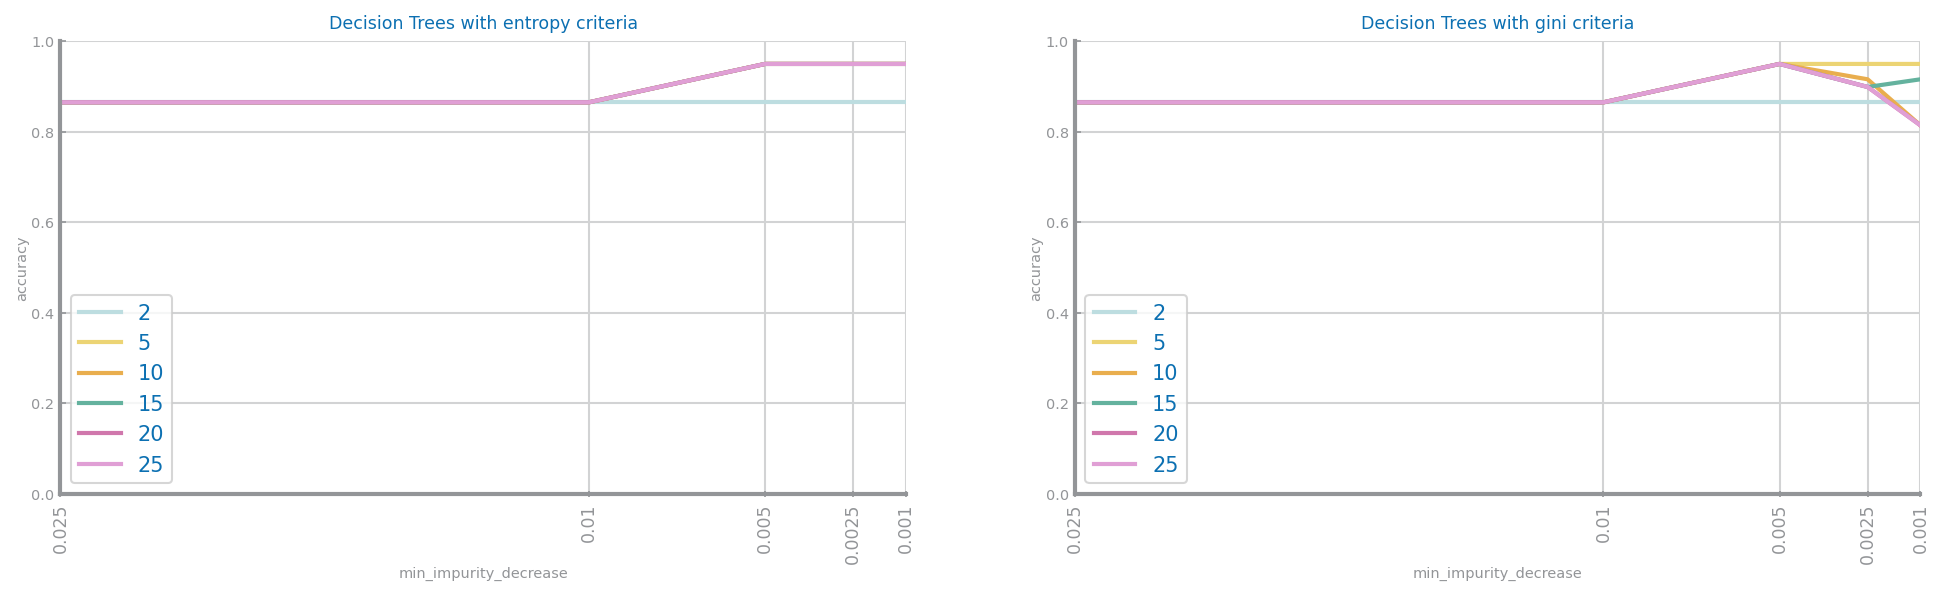

Best results achieved with entropy criteria, depth=5 and min_impurity_decrease=0.01 ==> accuracy=0.95
Confusion Matrix Test
TruePositives:  1
FalsePositives:  1
TrueNegatives:  55
FalseNegatives:  2


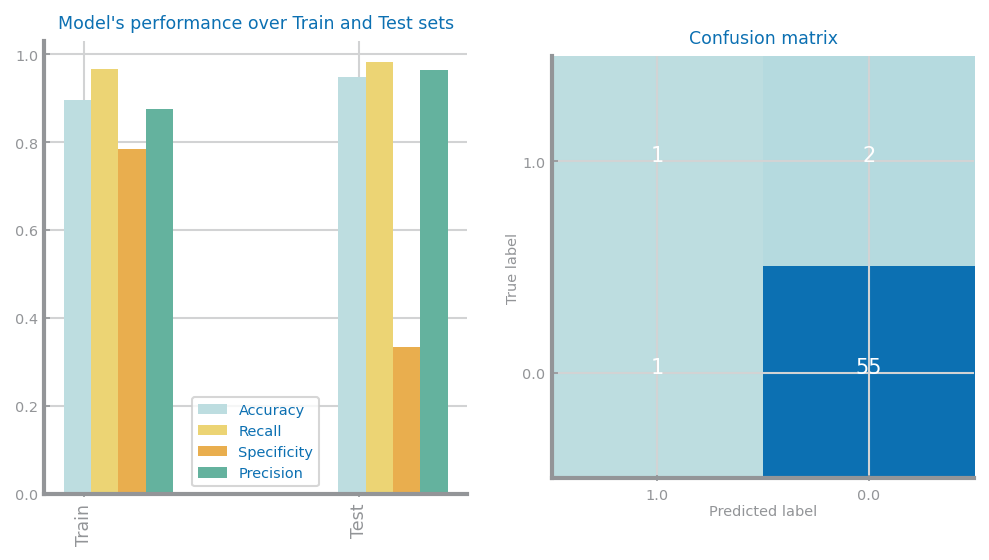

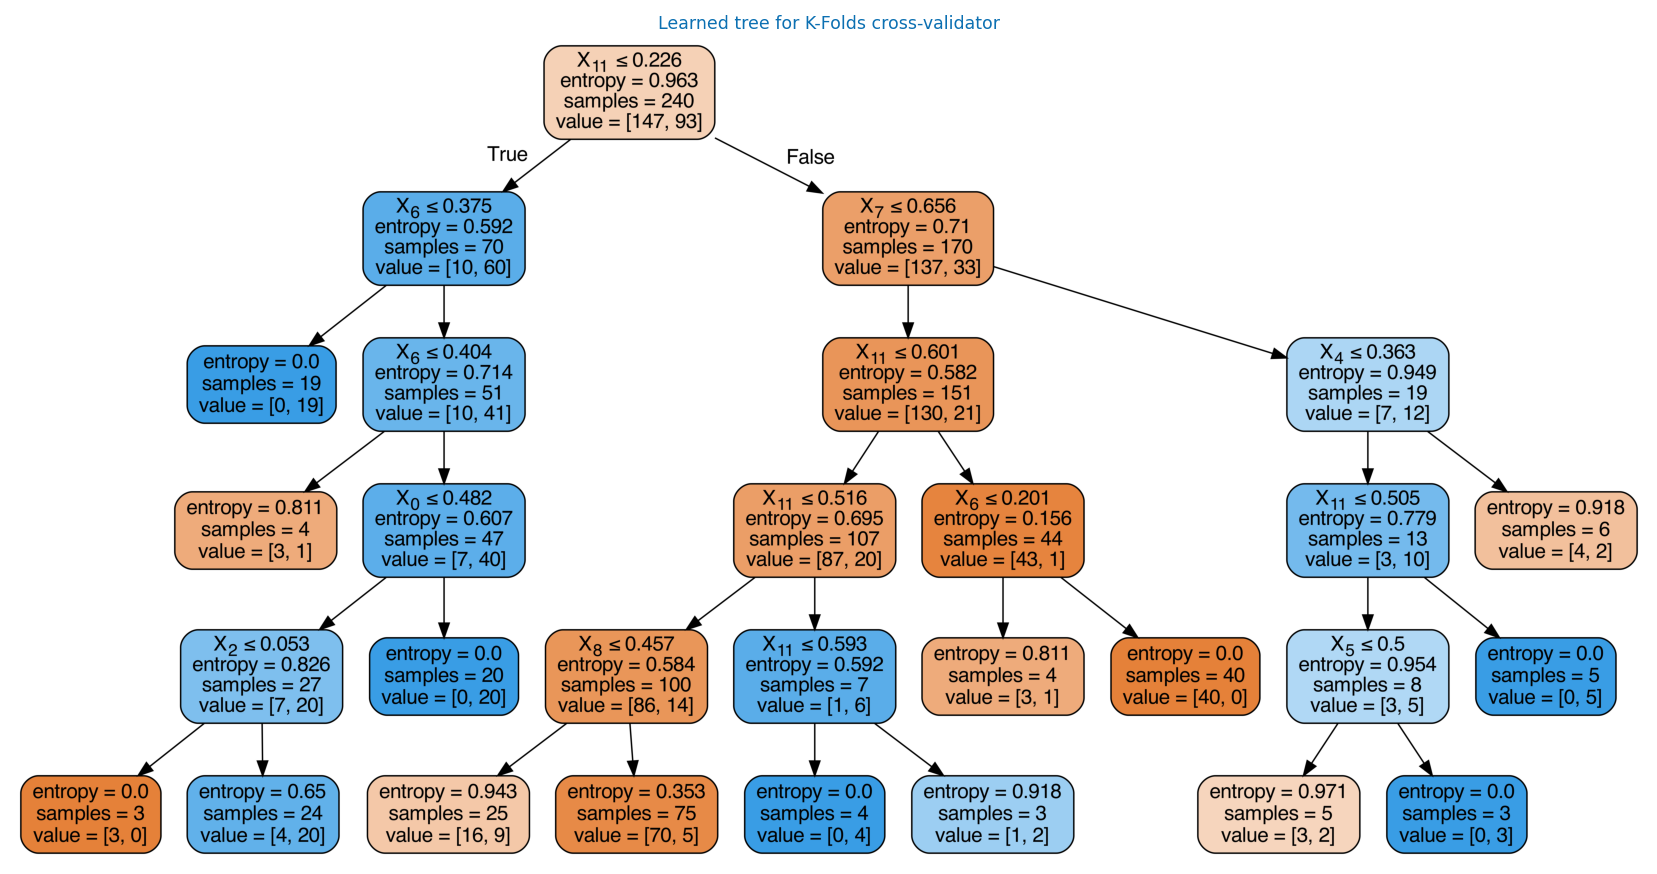

In [21]:
decision_tree_kfold(num_splits_kfold=5, data=norm_data_minmax_clean, n=3, stratified=False)

# Overfitting

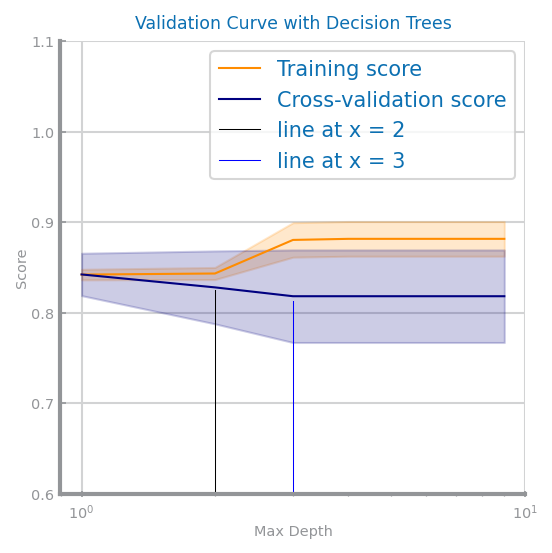

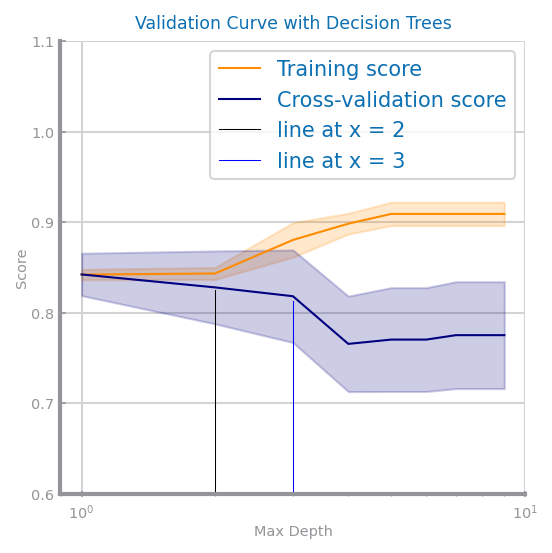

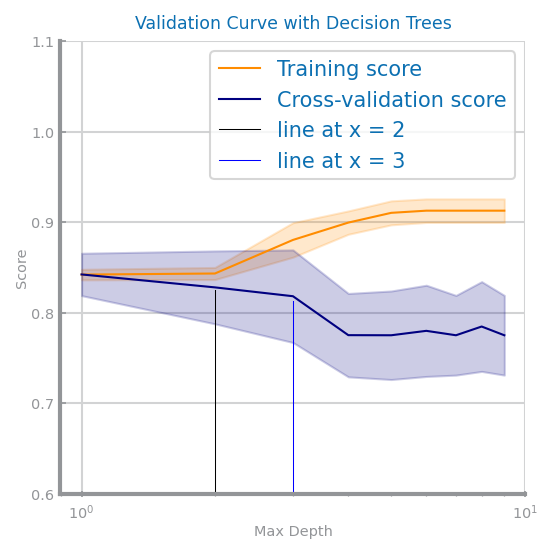

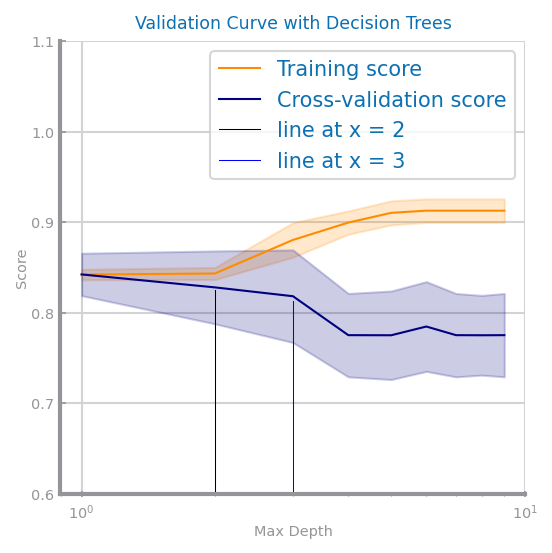

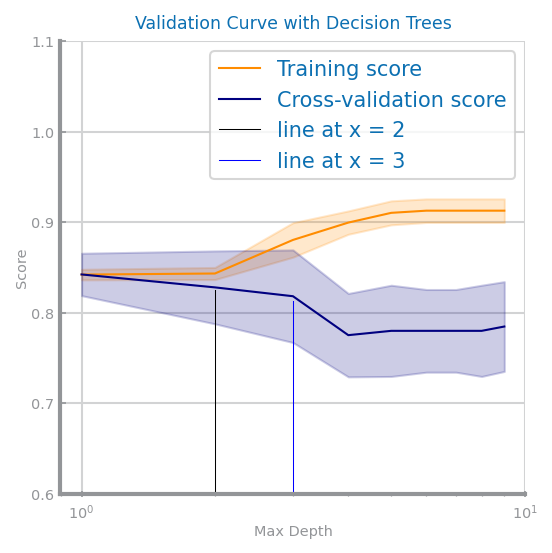

In [22]:
min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
for imp in min_impurity_decrease:
    fig = plt.figure(figsize=(4,4))
    max_depths = [i for i in range(10)]
    train_scores, test_scores = validation_curve(
        DecisionTreeClassifier(min_samples_leaf=5, criterion='entropy', min_impurity_decrease=imp), trnX, trnY, param_name="max_depth", param_range=max_depths,
        scoring="accuracy", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ymin = 0.6
    ymax = 1.1
    plt.title("Validation Curve with Decision Trees")
    plt.xlabel("Max Depth")
    plt.ylabel("Score")
    plt.ylim(ymin, ymax)
    lw = 1
    plt.semilogx(max_depths, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(max_depths, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(max_depths, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(max_depths, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)

    # x coordinates for the lines
    xcoords = [2,3]
    # colors for the lines
    colors = ['k','b']
    # height of lines
    height = [test_scores_mean[xcoords[0]]*0.545,test_scores_mean[xcoords[1]]*0.52]

    for xc,c,h in zip(xcoords,colors,height):
        plt.axvline(x=xc, label='line at x = {}'.format(xc), c=c, linewidth=0.5, ymax = h)
    
    plt.legend(loc='best')
    plt.show()

Regarding entropy criteria, for all the min_impurity_decrease tested values there is a **loss in testing score that comes with the gain of training score at from depth=2 to depth=3**. This probably means that the model is adapting to the noise present in our dataset and therefore losing its ability to generalize the information - overfitting.

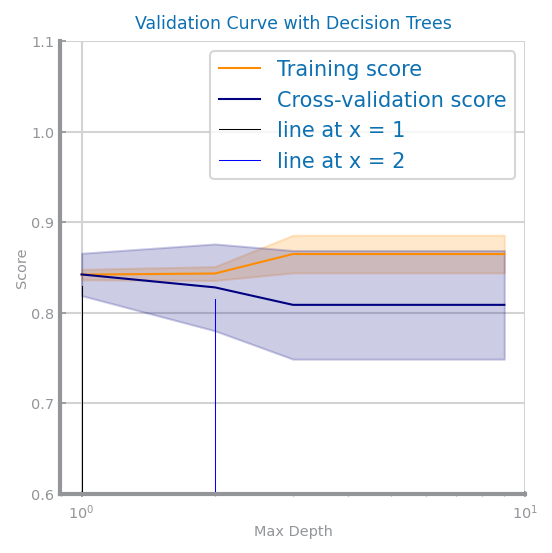

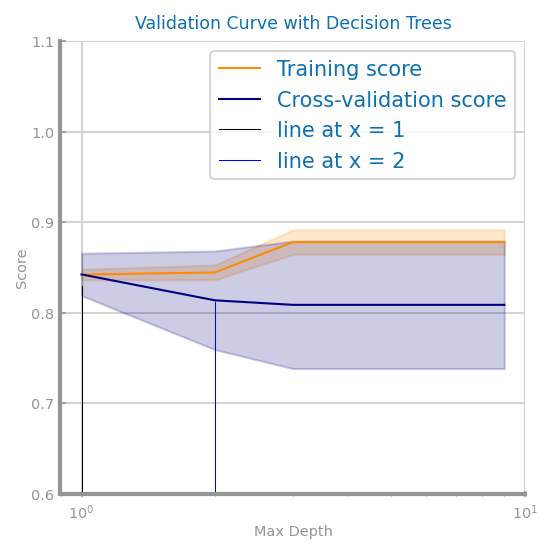

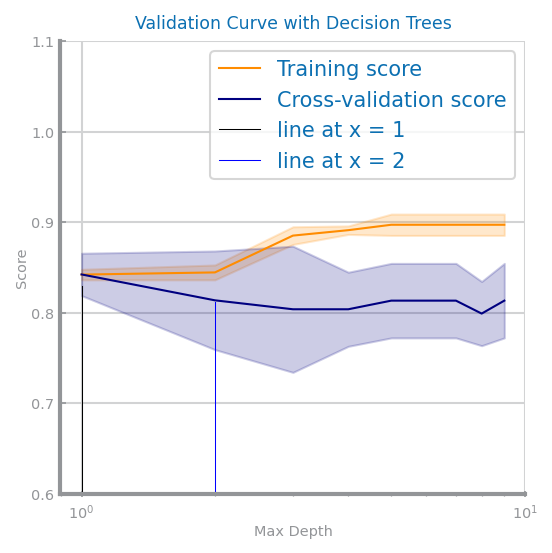

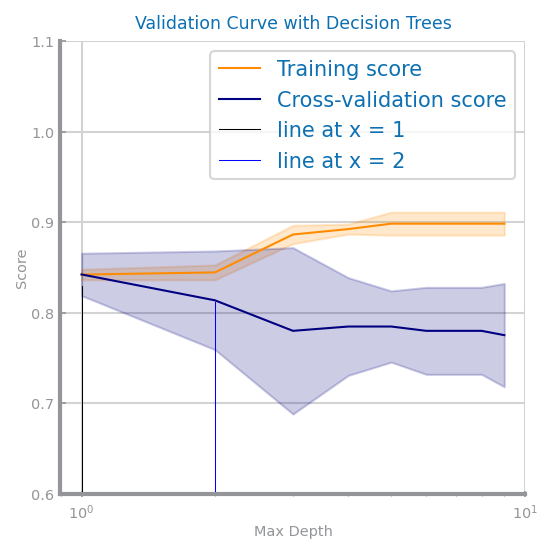

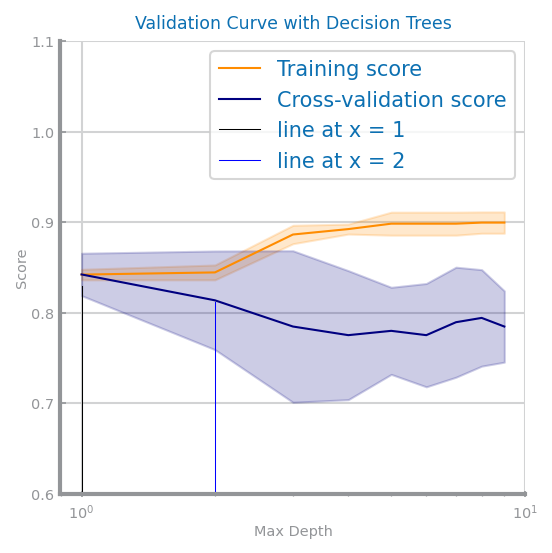

In [23]:
min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
for imp in min_impurity_decrease:
    fig = plt.figure(figsize=(4,4))
    max_depths = [i for i in range(10)]
    train_scores, test_scores = validation_curve(
        DecisionTreeClassifier(min_samples_leaf=5, criterion='gini', min_impurity_decrease=imp), trnX, trnY, param_name="max_depth", param_range=max_depths,
        scoring="accuracy", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ymin = 0.6
    ymax = 1.1
    plt.title("Validation Curve with Decision Trees")
    plt.xlabel("Max Depth")
    plt.ylabel("Score")
    plt.ylim(ymin, ymax)
    lw = 1
    plt.semilogx(max_depths, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(max_depths, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(max_depths, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(max_depths, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)

    # x coordinates for the lines
    xcoords = [1,2]
    # colors for the lines
    colors = ['k','b']
    # height of lines
    height = [test_scores_mean[xcoords[0]]*0.545,test_scores_mean[xcoords[1]]*0.52]

    for xc,c,h in zip(xcoords,colors,height):
        plt.axvline(x=xc, label='line at x = {}'.format(xc), c=c, linewidth=0.5, ymax = h)
    
    plt.legend(loc='best')
    plt.show()

Regarding gini criteria, for all the min_impurity_decrease tested values there is also a **loss in testing score that comes with the gain of training score but this time when depth increases from 1 to 2**. This probably means that the model is adapting to the noise present in our dataset and therefore losing its ability to generalize the information - overfitting.
*Note: there may be some learning gain with using a three with depth up to 3 as we can see from the shadow area.*